# Grammar of personhood (machine learning)



## Intro

I'm working on my personification chapter now. So far I've measured an ["agency index"](https://twitter.com/quadrismegistus/status/1059305496211931136), trying to find trends in how words gain/lose (syntactic) "agency" over time. This has been interesting, but what's missing is that personifications don't just do things (as the agency index captures), they do *human* things ("let not Ambition *mock*") and have *human* things ("Honour's voice").

So I'm trying to move on from this 'syntax of agency' to a broader 'grammar of personhood'. I took a failed stopover at the 'semantics of personhood' via word2vec: my 'human words' vector didn't end up being that interesting an index for other words, i.e. didn't seem to capture personification effects. Now I'm moving back to the syntactic BookNLP-style data (subject-verb, modifier-noun, etc) I've collected about the nouns for the Chadwyck Healey poetry collections.

I'm wondering whether a classifier to separate human vs. non-human (maybe human vs. object) words by way of the distribution of other words ('collocated' by syntax): and then use that classifier to estimate the 'humanness' of all words, not just those in the cross-validation experiment? I did this in a smaller related project on animal stories, and according to the cross-validation results, the model found it easier to separate humans and animals in novels than it did in these anthropomorphic animal stories, which seemed right. But here I want to use a classifier to estimate the humanness of all, even non-human/object words like abstract nouns, to see if that changes over time?

#### Working with this data (*data.booknlp_like_data.chadwyck_poetry.txt.gz*) to *data_booknlp/*
Generated by [this notebook](BookNLP-like-Data.ipynb) on Sherlock.

Data appears as:

| fn             | head     | num_sent | rel      | word      |
|----------------|----------|----------|----------|-----------|
| Z400605772.xml | are      | 1        | nsubj    | hills     |
| Z400605772.xml | knows    | 2        | dobj     | roads     |
| Z400605772.xml | knows    | 2        | conj     | moves     |
| Z400605772.xml | in       | 3        | pobj     | circles   |
| Z400605772.xml | within   | 3        | pobj     | head      |
| Z400605772.xml | has      | 4        | dobj     | say       |
| Z400605772.xml | is       | 5        | nsubj    | river     |
| Z400605772.xml | lie      | 5        | nsubj    | winds     |
| Z400605772.xml | at       | 6        | pobj     | dawn      |
| Z400605772.xml | sees     | 6        | dobj     | skies     |
| Z400605772.xml | feels    | 7        | nsubj    | shadows   |
| Z400605772.xml | of       | 7        | pobj     | night     |
| Z400605772.xml | recline  | 7        | dobj     | fingers   |
| Z400605772.xml | on       | 7        | pobj     | eyes      |
| Z400605772.xml | welcomes | 8        | dobj     | sun       |
| Z400605772.xml | sun      | 8        | conj     | rain      |
| Z400605772.xml | has      | 9        | nsubj    | landscape |
| Z400605772.xml | has      | 9        | dobj     | depth     |
| Z400605772.xml | depth    | 9        | conj     | height    |
| Z400605772.xml | city     | 10       | ROOT     | city      |
| Z400605772.xml | burns    | 10       | compound | passion   |
| Z400605772.xml | like     | 10       | pobj     | burns     |
| Z400605772.xml | walks    | 11       | compound | morning   |
| Z400605772.xml | of       | 11       | pobj     | walks     |
| Z400605772.xml | on       | 11       | pobj     | wave      |
| Z400605772.xml | of       | 11       | pobj     | sand      |

## Machine learning human nouns
Code adapted from the classification work in the [Wild Animal Stories notebook](http://localhost:8888/lab/tree/workspace%2Fwildanimalstories%2Fexperiments.ipynb).

#### Decide groups

In [23]:
import lit
CP=lit.load_corpus('ChadwyckPoetry')
CPgroups = CP.new_grouping()
CPgroups.group_by_author_at_30(yearbin=25)
CPgroups.prune_groups(min_group=1600,max_group=2000,min_len=10)
fn2group=dict((k.split('/')[-1]+'.xml',v) for k,v in CPgroups.textid2group.items())
fn2group.items()[:5]

>> reading config files...
>> streaming as tsv: /Users/ryan/DH/lit/corpus/chadwyck_poetry/corpus-metadata.ChadwyckPoetry.txt
   done [3.3 seconds]


[(u'Z200427100.xml', '1850-1874'),
 (u'Z200358033.xml', '1975-1999'),
 (u'Z400369280.xml', '1900-1924'),
 (u'Z300173395.xml', '1850-1874'),
 (u'Z200137391.xml', '1850-1874')]

In [24]:
from lit import tools
import os
def transform_booknlp_like_data(fn='data_booknlp/data.booknlp_like_data.chadwyck_poetry.txt.gz',
                                odir='data_booknlp/data_by_quarter_century/'):
    """
    save booknlp-like data in separate files by group
    """
    if not os.path.exists(odir): os.makedirs(odir)
    group2f={}
    header=None
    for dx in tools.readgen(fn):
        if not header: header=sorted(list(dx.keys()))
        group=fn2group.get(dx['fn'])
        if not group: continue
        dx['group']=group
        ofn=os.path.join(odir,group+'.txt')
        import codecs
        if not group in group2f:
            f=group2f[group]=codecs.open(ofn,'w',encoding='utf-8')
            f.write('\t'.join(h for h in header) + '\n')
        f=group2f[group]
        f.write('\t'.join(dx.get(h,'') for h in header) + '\n')

In [25]:
#transform_booknlp_like_data()

#transform_booknlp_like_data(fn='data_booknlp/data.booknlp_like_data.chadwyck_poetry.lemmatized.txt.gz',
#                            odir='data_booknlp/data_by_quarter_century_lemmatized/')
# last run (V2, lemmatized): 2/5/19 03:34 [I couldn't sleep]

#### Decide fields

In [26]:
FIELDS_WANTED = ['VG.Human','VG.Object','VG.Animal']

In [27]:
from lit.tools.freqs import get_fields
import pandas as pd
fields=get_fields()
#fields

>> streaming as tsv: /Users/ryan/DH/Dissertation/abstraction/words/data.fields.txt
   done [0.1 seconds]


In [28]:
word2field={}
for field in FIELDS_WANTED:
    field_words=fields.get(field,[])
    print '>>',field,len(field_words)
    for word in field_words:
        word2field[word]=field

word2field.items()[:25]

>> VG.Human 395
>> VG.Object 661
>> VG.Animal 82


[(u'peacock', 'VG.Animal'),
 (u'coach', 'VG.Human'),
 (u'liar', 'VG.Human'),
 (u'rabbit', 'VG.Animal'),
 (u'corps', 'VG.Human'),
 (u'fox', 'VG.Animal'),
 (u'bull', 'VG.Animal'),
 (u'dollar', 'VG.Object'),
 (u'commoner', 'VG.Human'),
 (u'obstruction', 'VG.Object'),
 (u'manager', 'VG.Human'),
 (u'pervert', 'VG.Human'),
 (u'gang', 'VG.Human'),
 (u'zinc', 'VG.Object'),
 (u'skin', 'VG.Object'),
 (u'aristocrat', 'VG.Human'),
 (u'chair', 'VG.Object'),
 (u'captain', 'VG.Human'),
 (u'milk', 'VG.Object'),
 (u'equipment', 'VG.Object'),
 (u'voter', 'VG.Human'),
 (u'grape', 'VG.Object'),
 (u'buddy', 'VG.Human'),
 (u'pioneer', 'VG.Human'),
 (u'gymnast', 'VG.Human')]

#### Decide rels

In [29]:
# all of these from spacy: https://spacy.io/api/annotation
# spacy uses the ClearNLP tags for English:
# https://github.com/clir/clearnlp-guidelines/blob/master/md/specifications/dependency_labels.md

rels = {
    'poss':'Possessive',
    'nsubj':'Subject',
    'nsubjpass':'Subject (passive)',
    'dobj':'Object (direct)',
    'amod':'Modifier (adjective)',
    #'compound':'Modifier (noun->noun)',
    #'appos':'Modifier (noun<-noun)',
    #'attr':'Modifier (predicate?)',   # not in universal schema
    'dative':'Object (indirect)'       # not in universal schema [instead, "iobj"]
}

rel_is_backwards = {'amod'}            # these rels put the head on the non-noun as opposed to others

REL_WORD = True  # True for rel_word ('dobj_roads') or False for word (just 'roads')

#### Within groups, start classifying

In [30]:
def open_group_file(fn='data_booknlp/data_by_quarter_century/1600-1624.txt',only_rels=rels,only_fields=True):
    import pandas as pd
    df=pd.read_csv(fn,sep='\t',encoding='utf-8',quoting=3,error_bad_lines=False)
    
    if only_rels: df=df.loc[df.rel.isin(rels)]
    df['field']=[word2field.get(w,'') for w in df.word]
    if only_fields: df=df.loc[df.field!='']
    return df

In [31]:
#df = open_group_file()
df = open_group_file(fn='data_booknlp/data_by_quarter_century_lemmatized/1600-1624.txt')
df.head()

,fn,head,num_sent,rel,word,field
9,Z200410536.xml,attempt,5,nsubj,man,VG.Human
22,Z200410536.xml,assay,15,nsubj,foe,VG.Human
26,Z200410536.xml,lift,17,poss,hand,VG.Object
28,Z200410536.xml,act,17,nsubj,hand,VG.Object
85,Z300448748.xml,gainst,1,nsubj,finger,VG.Object


In [32]:
i,row=df.iterrows().next()
row['rel']
#list(df.to_dict('records'))

u'nsubj'

In [33]:
def make_crosstabs(df,lim_cols=2000,row_sum_min=10,syntax=False,rel_word=REL_WORD):
    if rel_word:
        df['rel_head']=[unicode(row.get('rel',''))+'_'+unicode(row.get('head','')) for row in df.to_dict('records')]
        #dfc=pd.crosstab(df['word'],df['rel_head'])

        # @new --> leave in rel's by themselves too -->
        left=pd.crosstab(df['word'], df['rel_head'])
        right=pd.crosstab(df['word'], df['rel'])
        dfc=left.join(right,rsuffix='_rel')
    else:
        left=pd.crosstab(df['word'], df['head'])
        right=pd.crosstab(df['word'], df['rel'])
        dfc=left.join(right,rsuffix='_rel')

    dfc=dfc.loc[dfc.sum(axis=1)>row_sum_min]
    cols=list(dfc.sum(axis=0).nlargest(lim_cols).index)
    dfc=dfc[cols]
    ## add field
    dfc['_field']=[word2field.get(w,'') for w in dfc.index]
    return dfc

In [34]:
dfc=make_crosstabs(df)
dfc.head()

,nsubj,dobj,nsubj_be,nsubjpass,poss,dobj_have,nsubj_do,...,nsubj_toil,nsubj_true,nsubj_unfeign,nsubj_unto,nsubj_wall,nsubj_weal,_field
word,,,,,,,,,,,,,,,
acquaintance,19,24,3,1,0,2,0,...,0,0,0,0,0,0,VG.Human
actor,9,3,1,1,0,1,0,...,0,0,0,0,0,0,VG.Human
adversary,30,4,8,2,0,0,0,...,0,0,0,0,0,0,VG.Human
ambassador,4,5,1,0,0,0,0,...,0,0,0,0,0,0,VG.Human
ancestor,22,7,6,0,0,3,0,...,0,0,0,0,0,0,VG.Human


In [35]:
pd.options.display.max_columns = 15
pd.options.display.max_rows = 10
dfc

,nsubj,dobj,nsubj_be,nsubjpass,poss,dobj_have,nsubj_do,...,nsubj_toil,nsubj_true,nsubj_unfeign,nsubj_unto,nsubj_wall,nsubj_weal,_field
word,,,,,,,,,,,,,,,
acquaintance,19,24,3,1,0,2,0,...,0,0,0,0,0,0,VG.Human
actor,9,3,1,1,0,1,0,...,0,0,0,0,0,0,VG.Human
adversary,30,4,8,2,0,0,0,...,0,0,0,0,0,0,VG.Human
ambassador,4,5,1,0,0,0,0,...,0,0,0,0,0,0,VG.Human
ancestor,22,7,6,0,0,3,0,...,0,0,0,0,0,0,VG.Human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
womb,60,61,7,3,0,3,2,...,0,0,0,0,0,0,VG.Object
wood,68,115,10,7,0,1,0,...,0,0,0,0,0,0,VG.Object
worker,11,6,6,2,0,0,0,...,0,0,0,0,0,0,VG.Human


In [36]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneOut

def classify(X,y):
    loo=LeaveOneOut()
    correct=[]
    for train_index, test_index in loo.split(X):
        clf = LogisticRegression(C=0.001)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        clf.fit(X_train,y_train)
        predictions=clf.predict(X_test)
        correct+=[int(y_test[0]==predictions[0])]
    return np.mean(correct)

from scipy.stats import zscore
def do_classification(df,target='_field',numruns=30,numsample=50,replace=False):
    target_types=set(list(df[target]))
    
    objects=[]
    for tt1 in target_types:
        for tt2 in target_types:
            if tt2<=tt1: continue
            for nr in range(numruns):
                objects+=[(tt1,tt2,nr)]
    
    import random
    random.shuffle(objects)
    numobj=len(objects)
    for i,(tt1,tt2,nr) in enumerate(objects):
        print i,numobj,tt1,tt2,nr,
        dfs=[df.loc[df[target]==tt] for tt in [tt1,tt2]]
        lens=[len(_df.index) for _df in dfs]
        minlen=min(lens)
        print lens,minlen,
        ns=numsample if numsample else minlen
        print ns,
        try:
            dfs_sample=[_df.sample(ns,replace=replace) for _df in dfs]
        except ValueError:
            print "!!"
            continue
        
        ndf=pd.concat(dfs_sample)
        Xdf=ndf.select_dtypes('number').apply(zscore).dropna(1)
        y=np.array([word2field[w] for w in Xdf.index])
        X=Xdf.values
        
        acc=classify(X,y)
        print acc
        odx={'class1':tt1,'class2':tt2,'accuracy':acc,'numruns':numruns,'numrun':nr,'numsample':numsample}
        #print odx
        yield odx

In [37]:
def classify_group_file(fn='data_booknlp/data_by_quarter_century/1600-1624.txt',
                        only_rels=rels,only_fields=True,
                        numruns=30,lim_cols=2000):
    df=open_group_file(fn=fn,only_rels=only_rels,only_fields=only_fields)
    df_tabs=make_crosstabs(df,lim_cols=lim_cols)
    for odx in do_classification(df_tabs,numruns=numruns):
        odx['fn']=os.path.basename(fn)
        odx['period_int']=fn.split('-')[0]
        yield odx

In [38]:
#classify_group_file().next()
classify_group_file(fn='data_booknlp/data_by_quarter_century_lemmatized/1600-1624.txt').next()

0 90 VG.Animal VG.Human 3 [39, 158] 39 50 !!
1 90 VG.Human VG.Object 11 [158, 359] 158 50

/Users/ryan/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


 0.67


{'accuracy': 0.67,
 'class1': 'VG.Human',
 'class2': 'VG.Object',
 'fn': '1600-1624.txt',
 'numrun': 11,
 'numruns': 30,
 'numsample': 50,
 'period_int': 'data_booknlp/data_by_quarter_century_lemmatized/1600'}

In [39]:
def do_classify_group_file(fn):
    return list(classify_group_file(fn))

def classify_all(idir='data_booknlp/data_by_quarter_century_lemmatized',lim_cols=2000):
    import multiprocessing as mp
    pool=mp.Pool()
    filenames = [os.path.join(idir,fn) for fn in os.listdir(idir) if fn.endswith('.txt')]
    for old in pool.imap_unordered(do_classify_group_file, filenames):
        for odx in old:
            yield odx

In [40]:
#tools.writegen('data_booknlp/data.classification_results.txt', classify_all)
# last run, V2 (with normalization), 2/4/19 15:09

#tools.writegen('data_booknlp/data.classification_results.txt', classify_all)
# last run, V3 (with rel_word), 2/4/19 16:15

#tools.writegen('data_booknlp/data.classification_results.v4-with-lemma.txt', classify_all)
# last run, V4 (with rel_word and lemma), 2/5/19 11:02

In [41]:
## for graphs...
WIDTH=600
from IPython.display import display, Image
def show(fn,width=WIDTH):
    return display(Image(fn,width=width))
################

### Results

#### Accuracy looks ok?
These are all binary classification problems. Thirty times (numruns) per quarter-century, predicting between 50 words (numsamples) of class1 and 50 words of class2, *without* standardization:

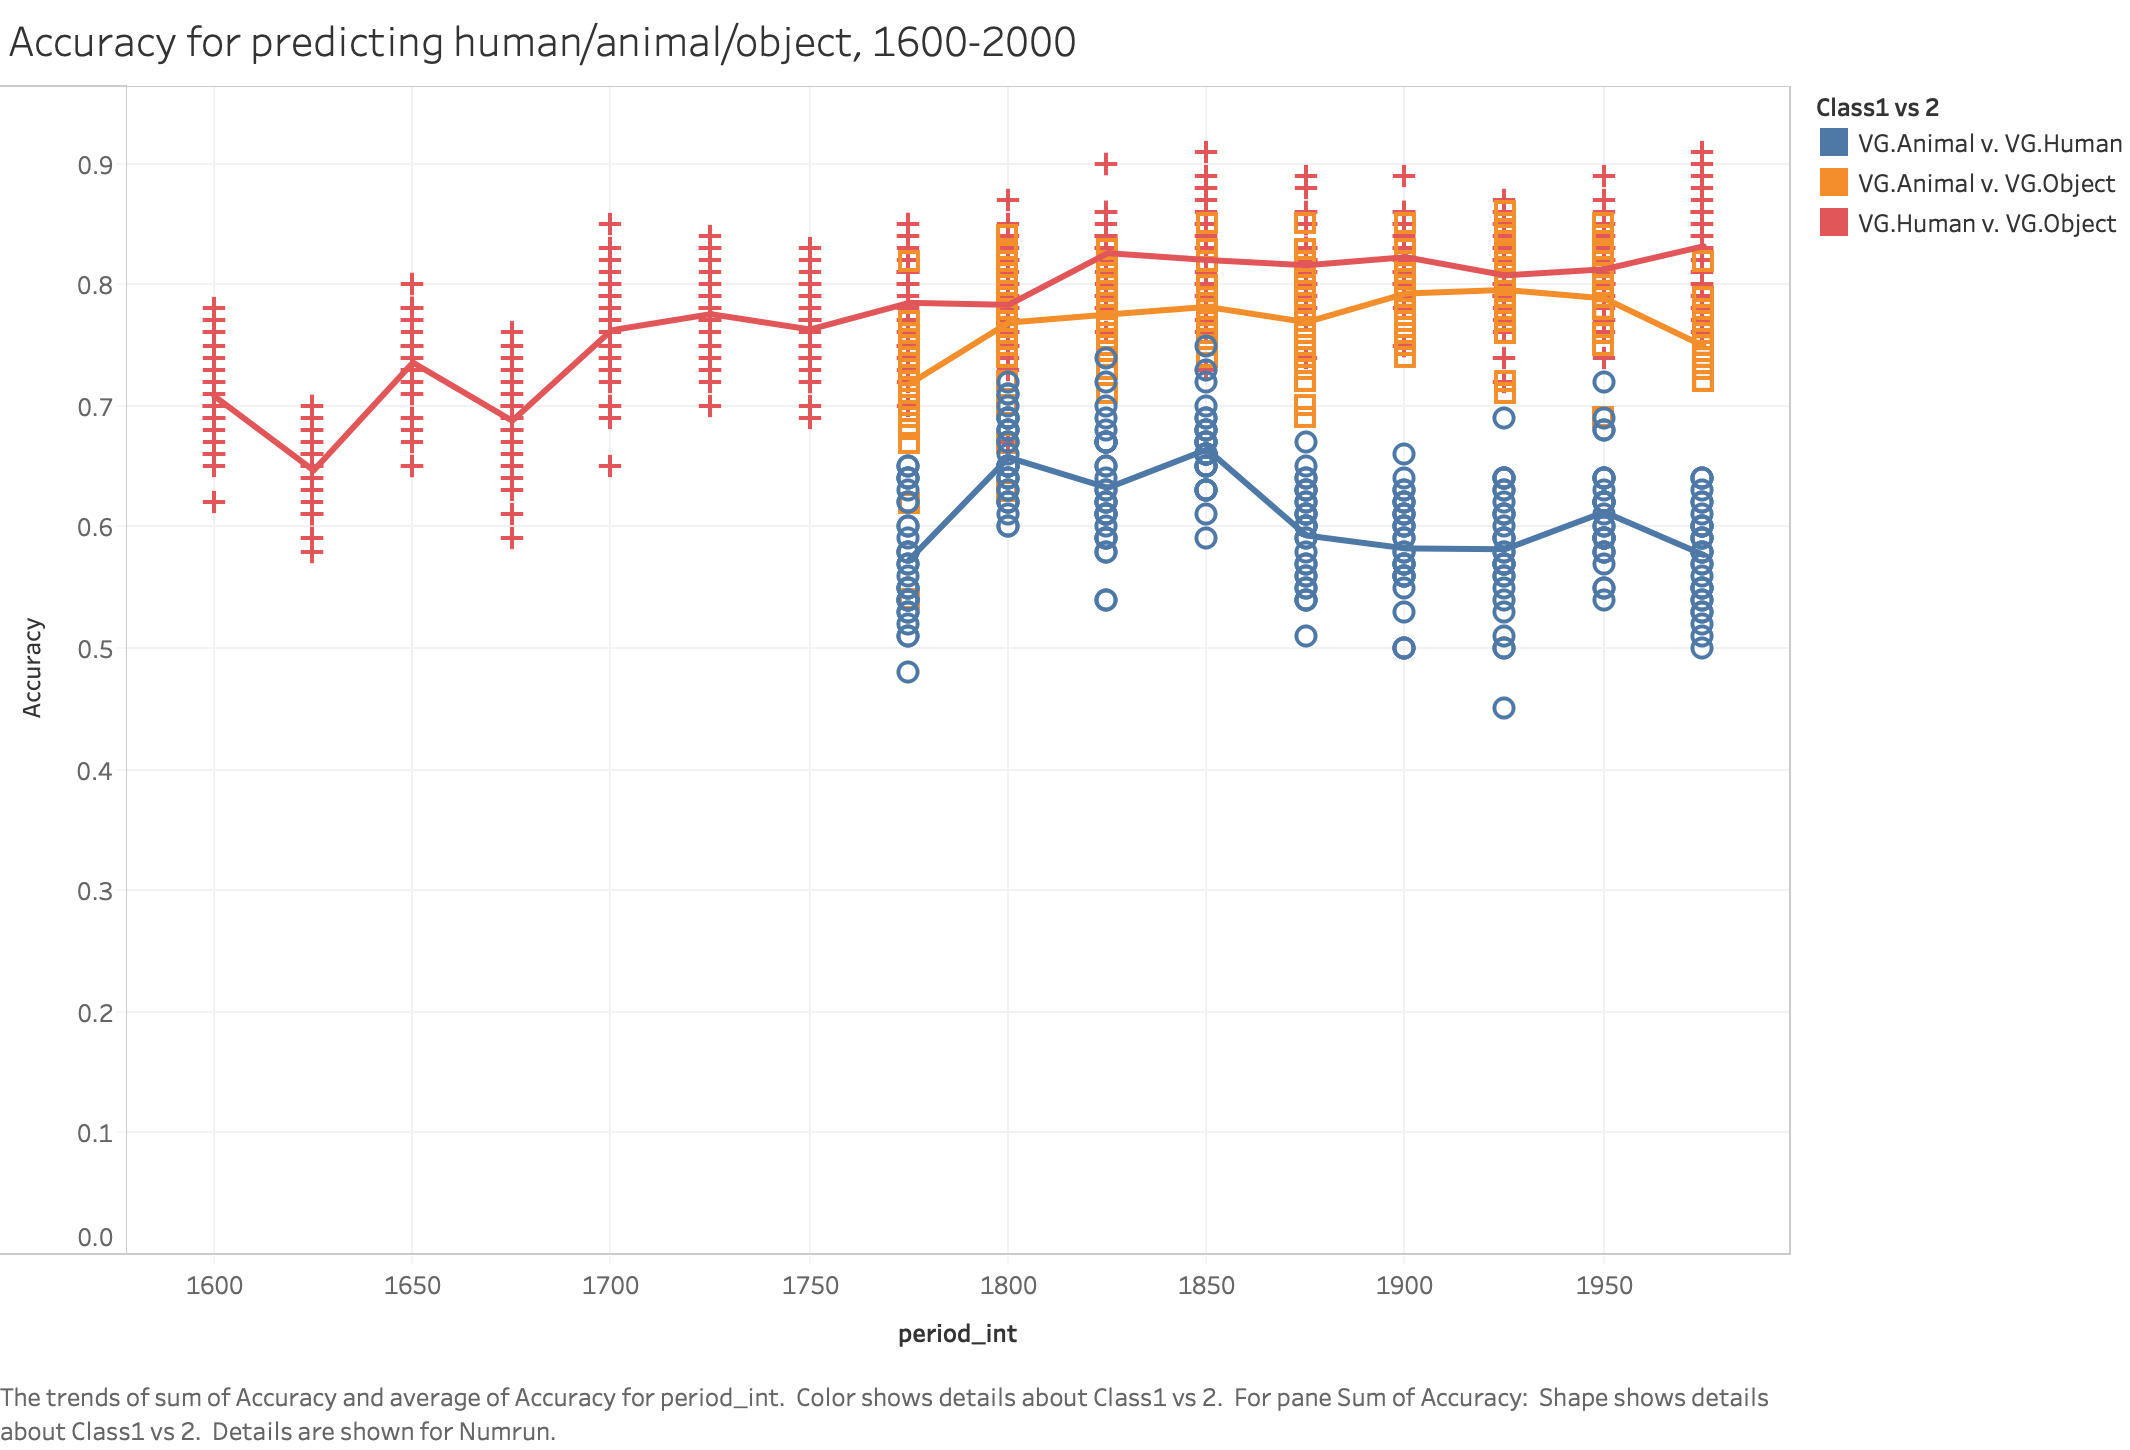

In [42]:
show('images/Accuracy for predicting humananimalobject, 1600-2000.png')

Accuracy gets worse when we turn on standardization (Z-score) for features. Why? [V2]

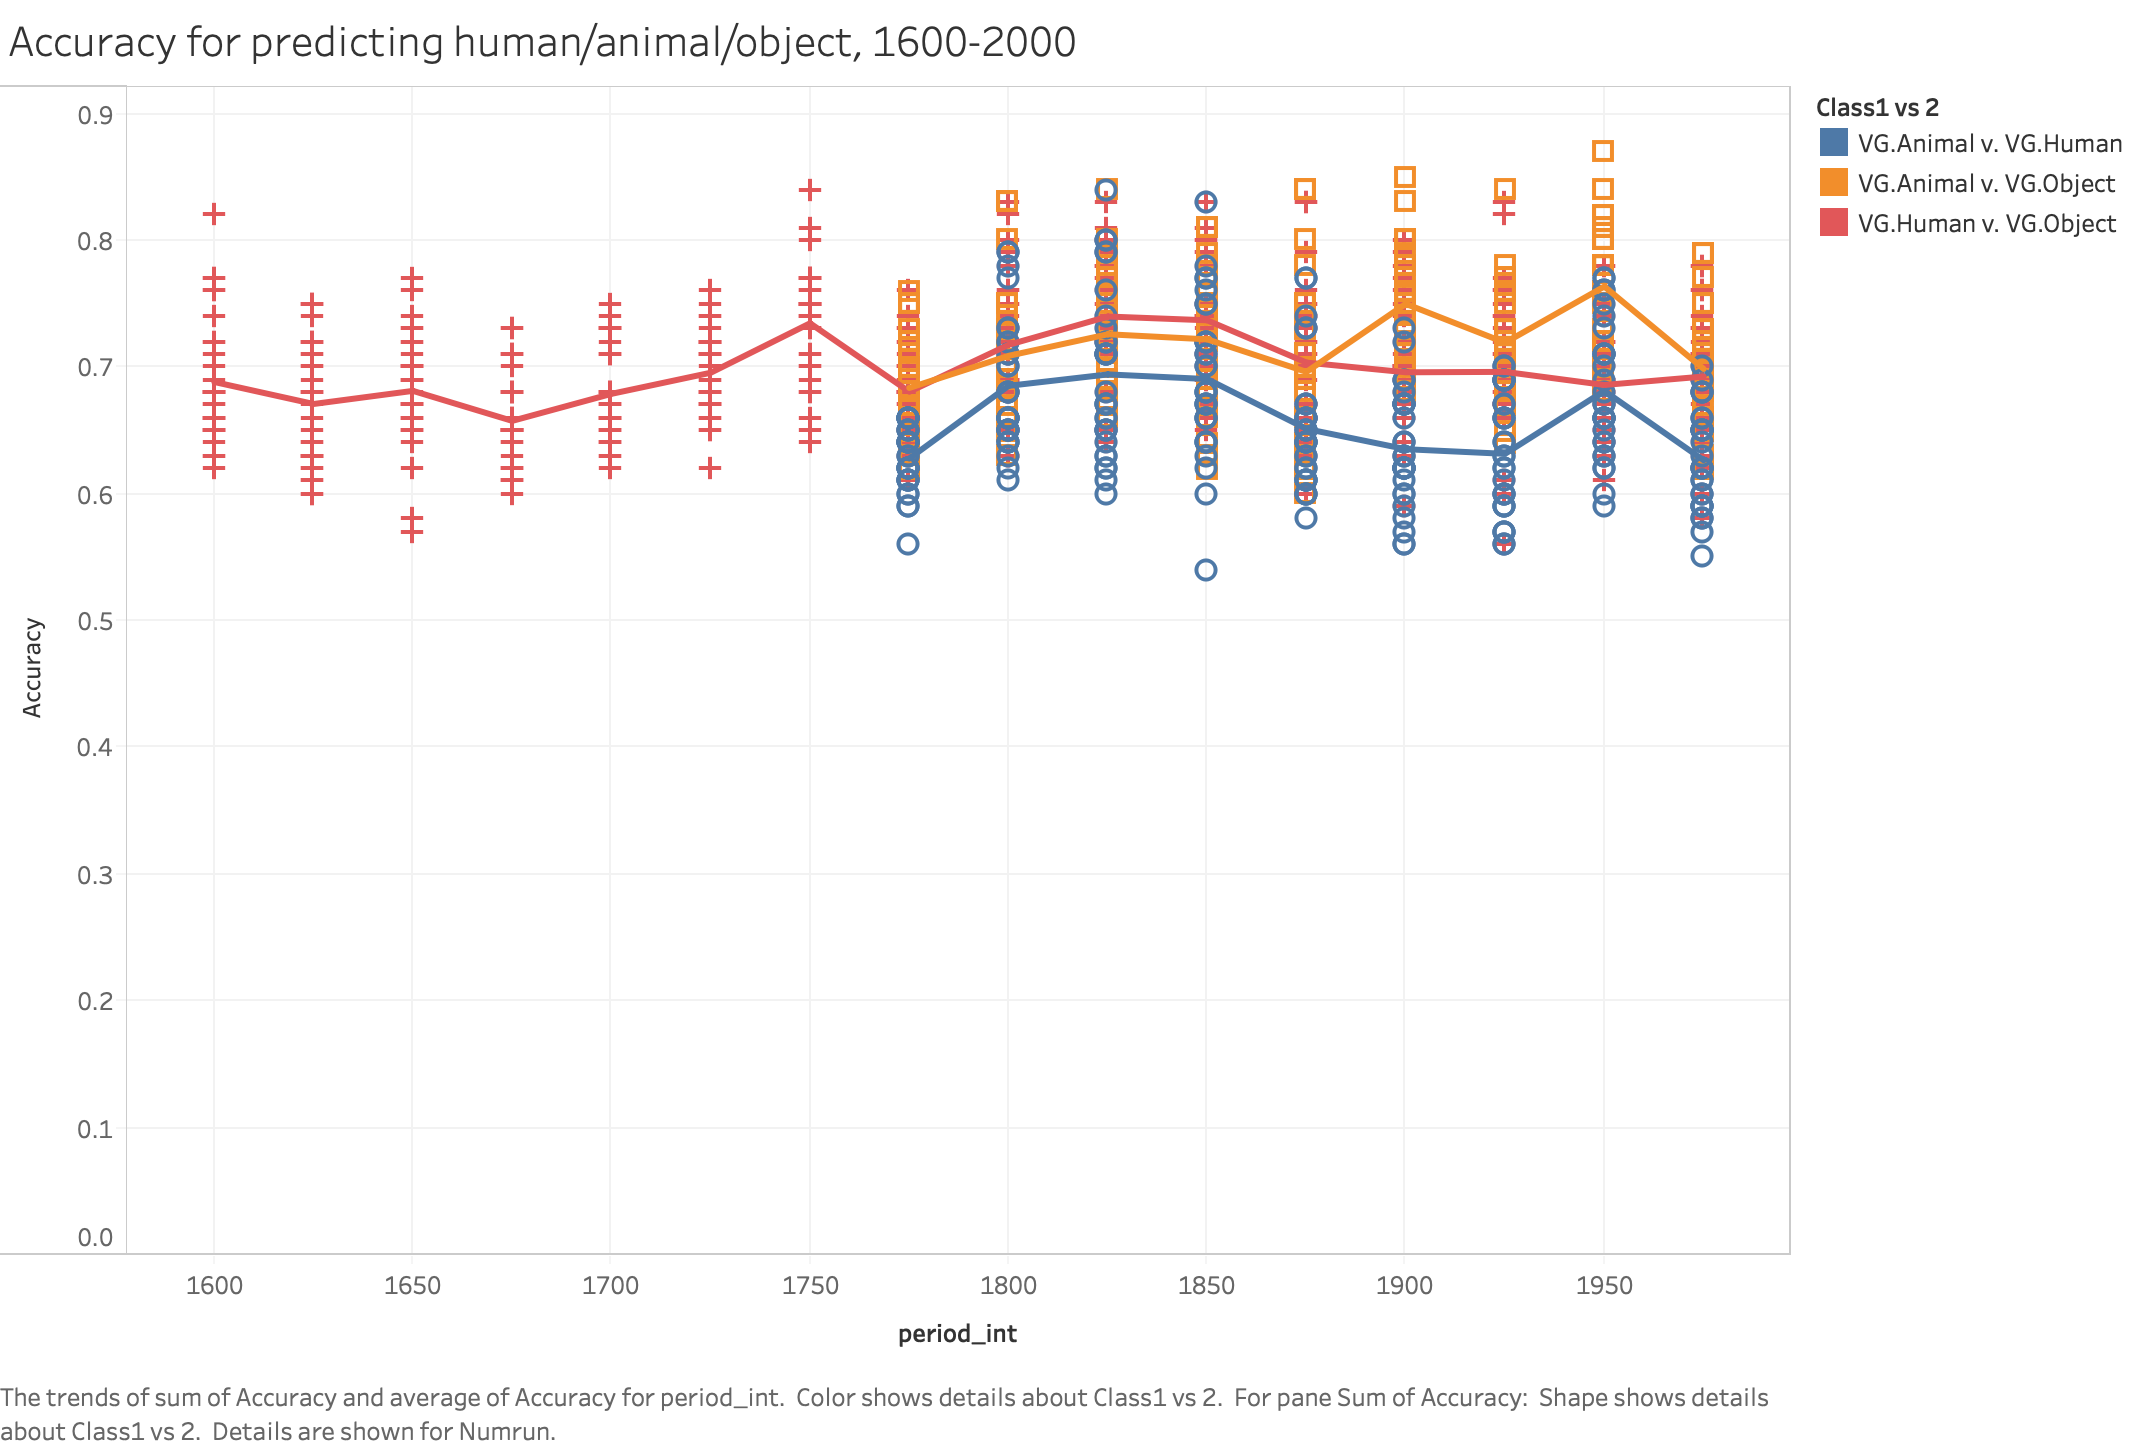

In [43]:
show('images/Accuracy for predicting humananimalobject, 1600-2000.V2 with standardization.png')

Accuracy marginally better when "rel_head" (eg *nsubj_knows*) is used [V3], i.e. and not just "head" (eg knows). (Z-scores used)

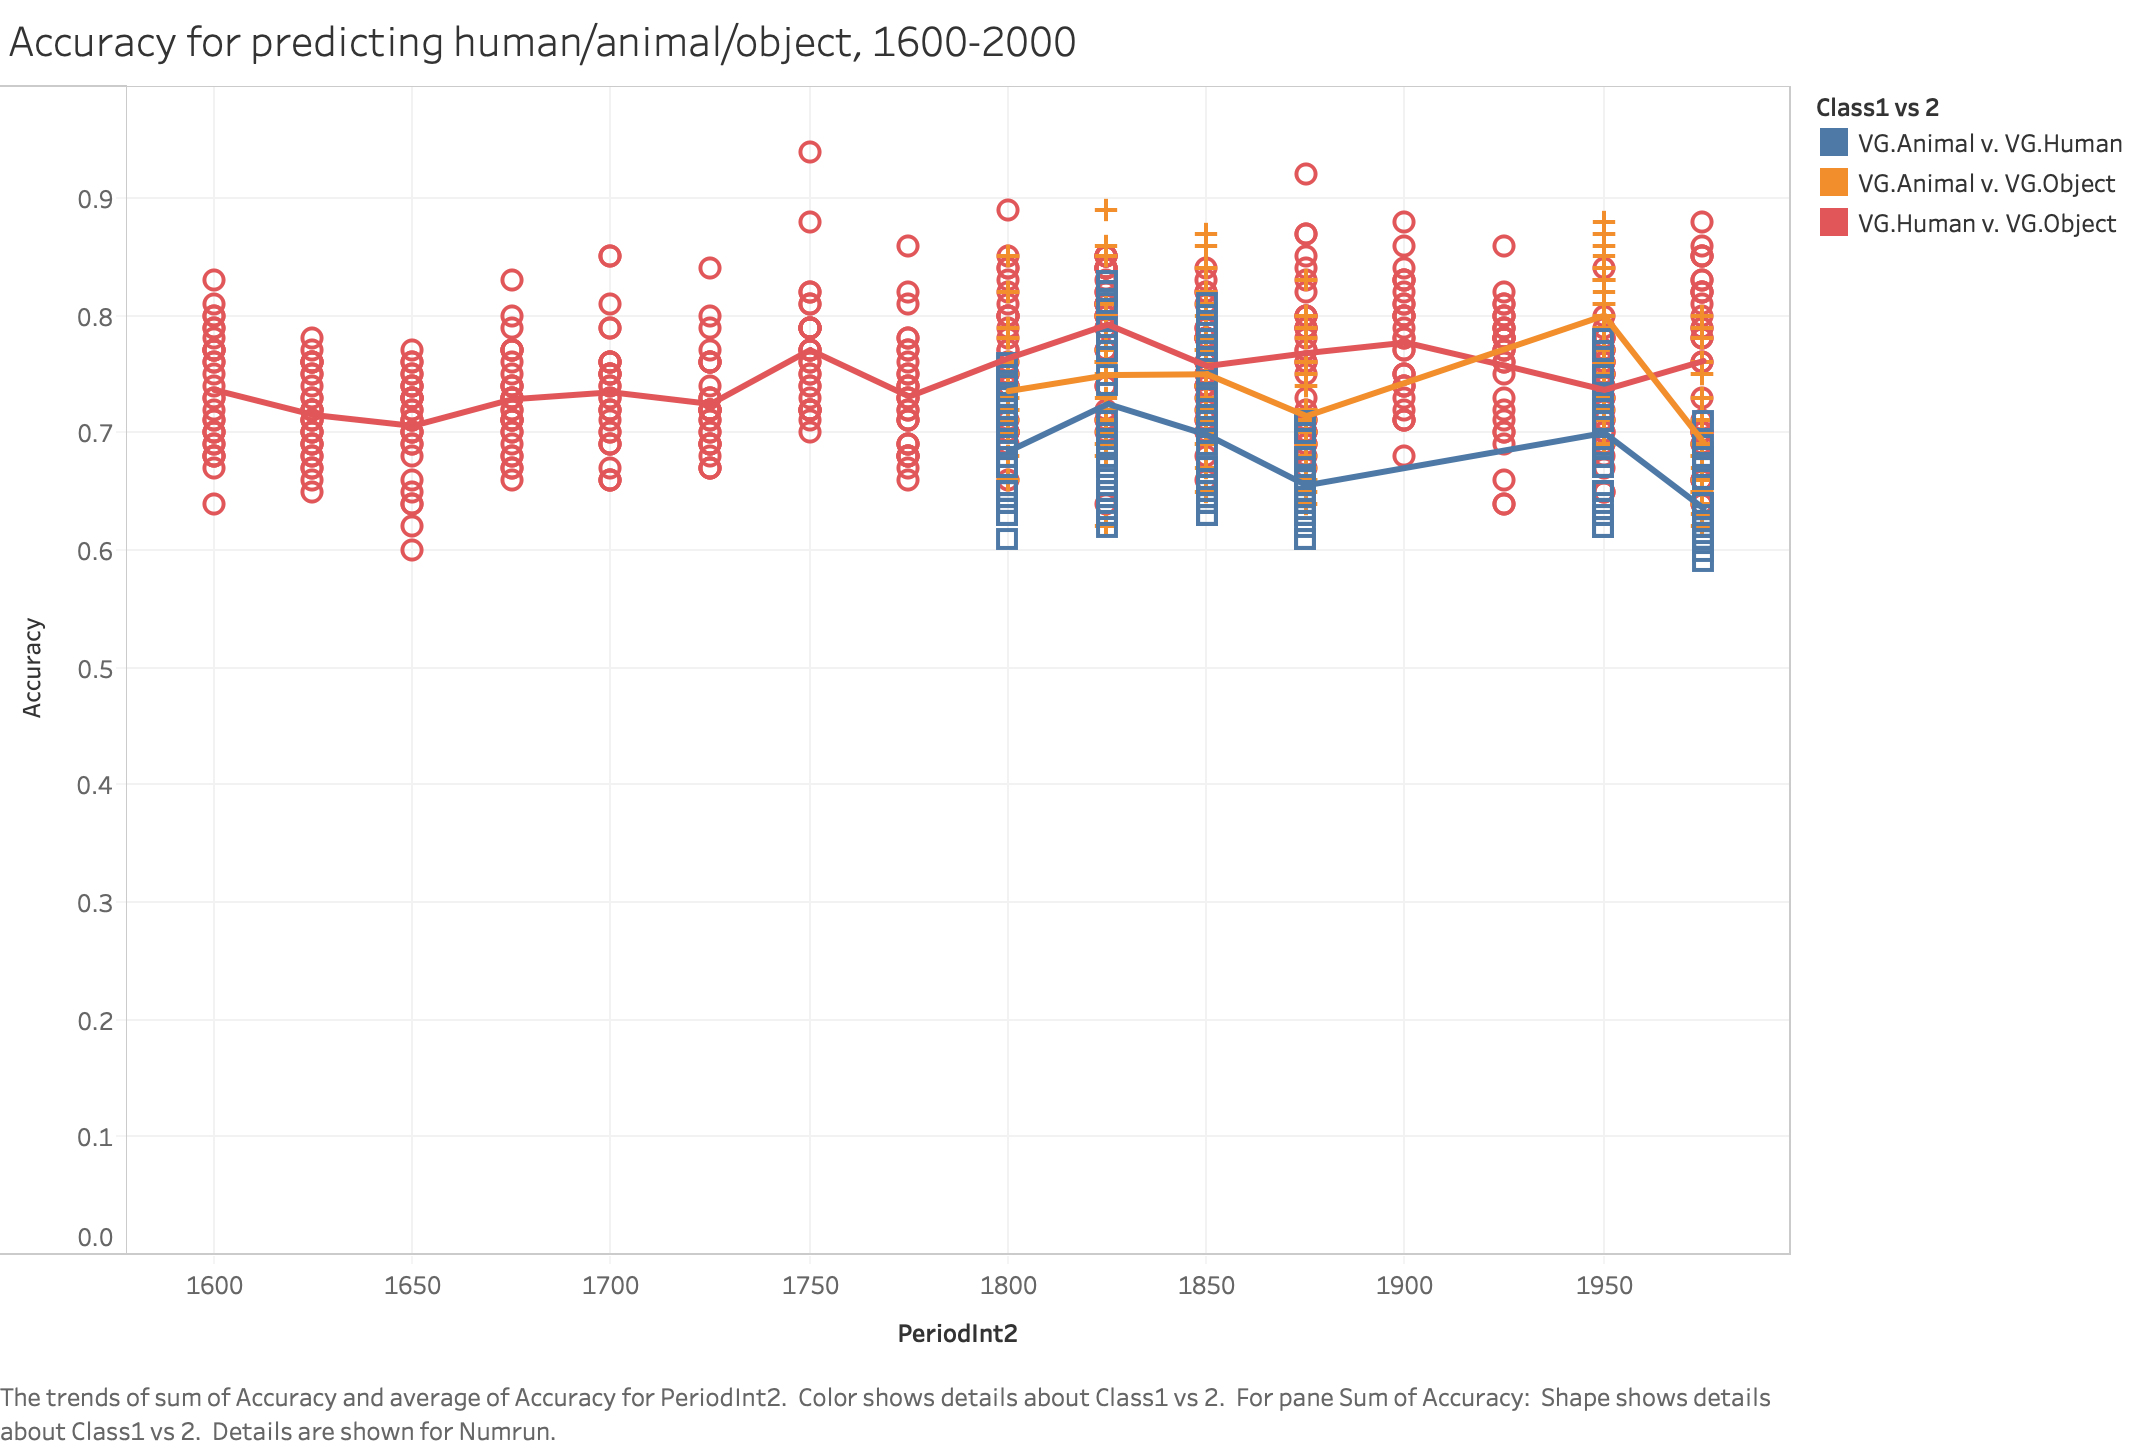

In [44]:
show('images/Accuracy for predicting humananimalobject, 1600-2000.V3 with rel_word.png')

Accuracy slightly worse when rel_lemma used not rel_word [V4] (as well as adding back in just the rel's)

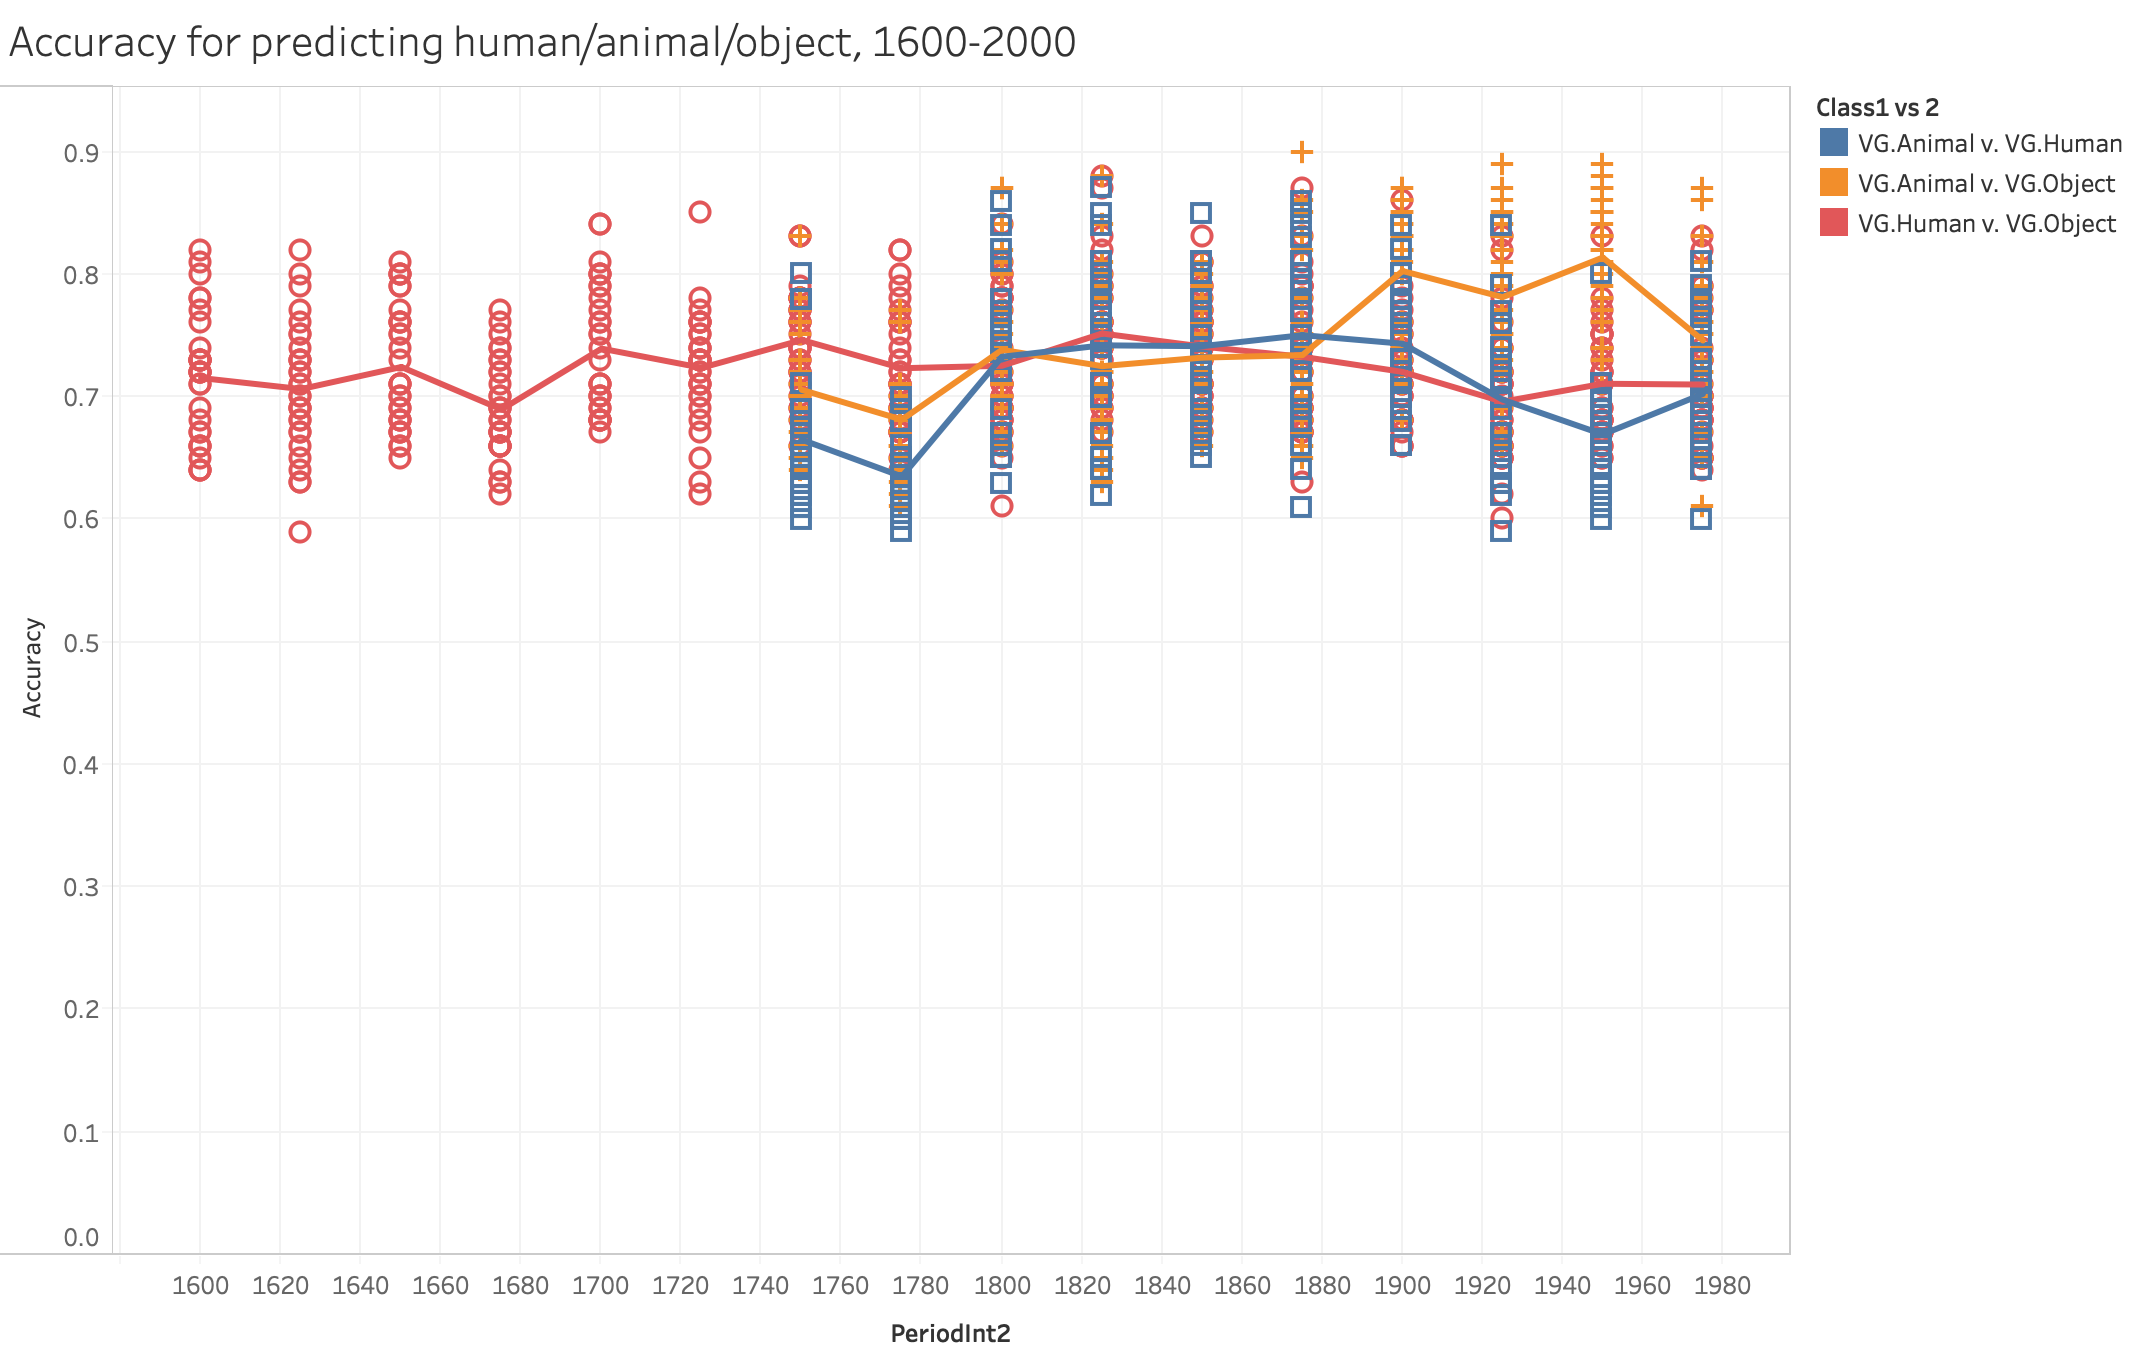

In [45]:
show('images/Accuracy for predicting humananimalobject, 1600-2000 -- V4 with lemma.png')

----

#### Median accuracy at the end of the day: **75%**, Human-vs-Object. Is that good enough to justify the next step?

This is V3, without lemmatization. Results slightly worse for V4 (median 72%, with lemmatization):

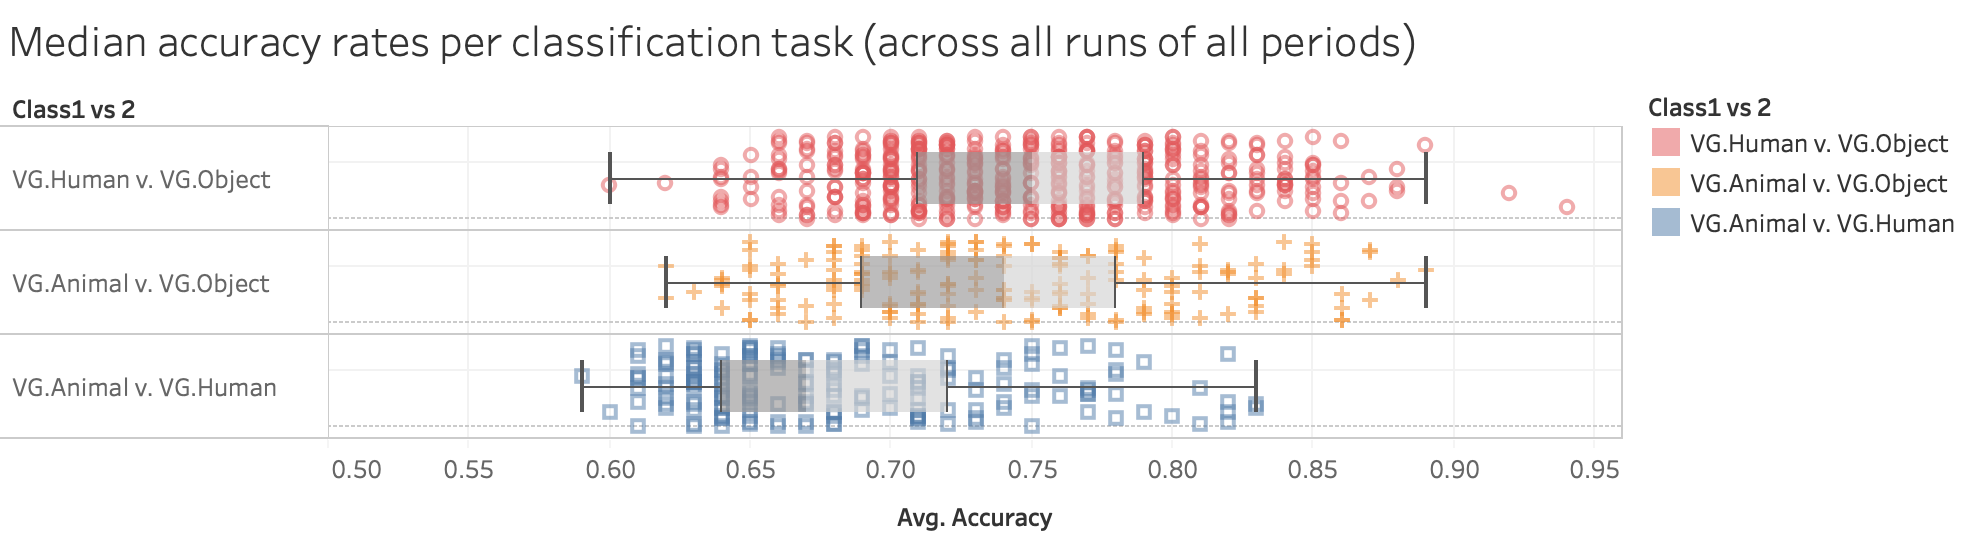

In [46]:
show('images/Median accuracy rates per classification task (across all runs of all periods).png',width=800)

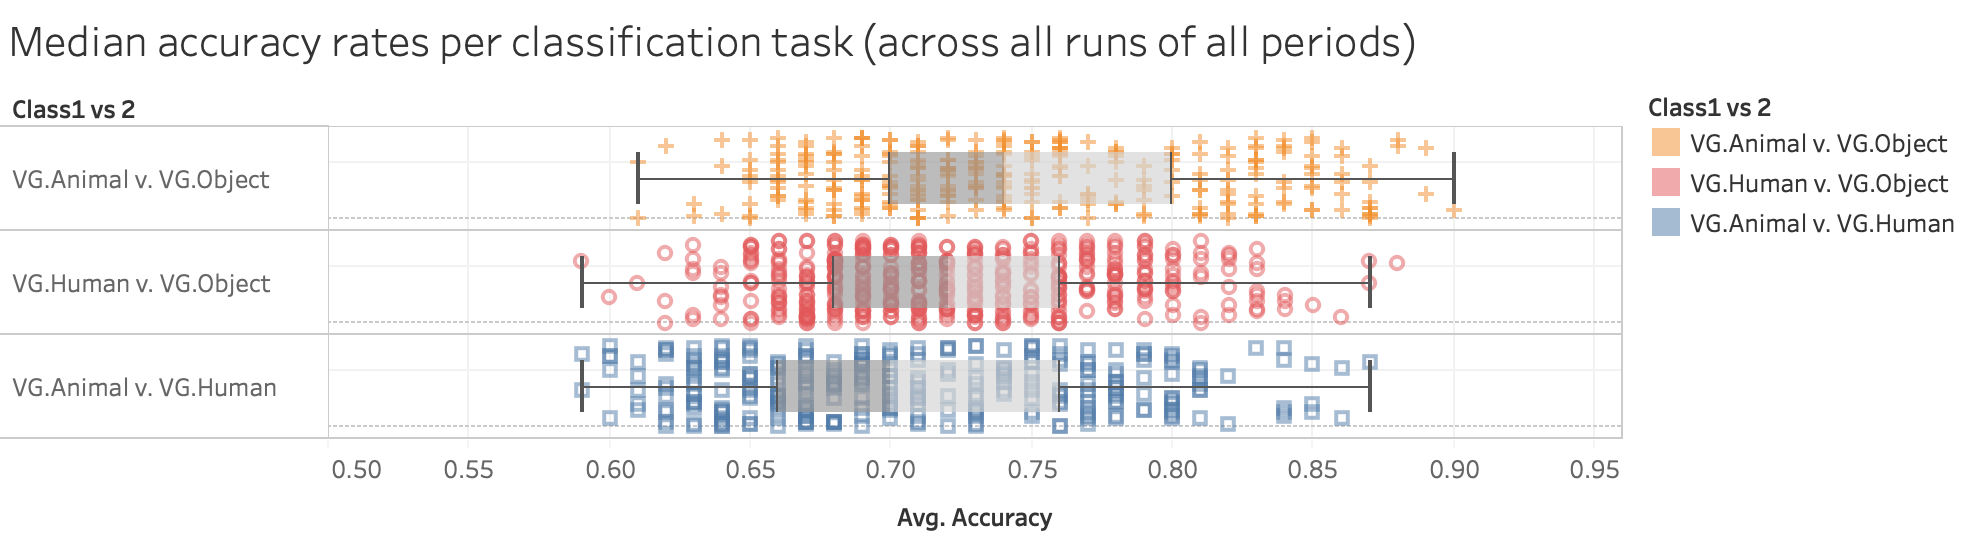

In [47]:
show('images/Median accuracy rates per classification task (across all runs of all periods) -- V4 with lemma.png',width=800)

## Next step: estimating humanness

Here we applying this machine-learnt model (separating human and objects) to estimate the 'humanness' of all other words in the data. We're not concerned with whether these estimations are “right,” per se, but more in the pattern of their wrongness: the word “nature” is not a person, but is there a history to its person-likeness? Is “nature” ever... dare I say... anthropomorphic: human-*like*, according to the model?


### Saving doc-term matrices

First let's save the document-term matrix of raw counts for each quarter-century, limited to the **lim_cols** most frequent words.

In [48]:
# Save crosstabs
CT_IDIR = 'data_booknlp/data_by_quarter_century/1600-1624.txt'
CT_ODIR = 'data_booknlp/data_by_quarter_century__crosstabs' if not REL_WORD else 'data_booknlp/data_by_quarter_century__crosstabs__rel_word2'
def save_crosstabs(fn=CT_IDIR,odir=CT_ODIR,
                    only_rels=rels,field1='VG.Human',field2='VG.Object',
                    row_sum_min=10,lim_cols=2000,rel_word=REL_WORD):
    df=pd.read_csv(fn,sep='\t',encoding='utf-8',quoting=3,error_bad_lines=False)
    
    if only_rels: df=df.loc[df.rel.isin(rels)]
    df['field']=[word2field.get(w,'') for w in df.word]
    #df=df.loc[df.field.isin({field1,field2})]
    
    ## make crosstabs
    if rel_word:
        print '>> crosstabbing rel_head counts',tools.now()
        df['rel_head']=[unicode(row.get('rel',''))+'_'+unicode(row.get('head','')) for row in df.to_dict('records')]
        counts_rel_head=pd.crosstab(df['word'],df['rel_head'])
        print '>> crosstabbing rel counts',tools.now()
        counts_rel=pd.crosstab(df['word'], df['rel'])
        print '>> joining tables',tools.now()
        df_tabs=counts_rel_head.join(counts_rel,rsuffix='_rel')
    else:
        print '>> crosstabbing head counts',tools.now()
        counts_head=pd.crosstab(df['word'], df['head'])
        print '>> crosstabbing rel counts',tools.now()
        counts_rel=pd.crosstab(df['word'], df['rel'])
        print '>> joining tables',tools.now()
        df_tabs=counts_head.join(counts_rel,rsuffix='_rel')
    print '>> filtering by row_sum_min',tools.now()
    if row_sum_min: df_tabs=df_tabs.loc[df_tabs.sum(axis=1)>row_sum_min]
    print '>> filtering by lim_cols',tools.now()
    if lim_cols:
        cols=list(df_tabs.sum(axis=0).nlargest(lim_cols).index)
        df_tabs=df_tabs[cols]
    ## add field
    print '>> adding new column',tools.now()
    df_tabs['_field']=[word2field.get(w,'') for w in df_tabs.index]
    
    if not os.path.exists(odir): os.makedirs(odir)
    ofnfn=os.path.join(odir, os.path.basename(fn))
    print '>> saving',tools.now()
    df_tabs.to_csv(ofnfn,sep='\t',encoding='utf-8')
    print '>> saved:',ofnfn,tools.now()

In [49]:
def save_all_crosstabs(idir='data_booknlp/data_by_quarter_century/',
                       odir='data_booknlp/data_by_quarter_century__crosstabs__rel_word/'):
    ifiles = [os.path.join(idir,ifn) for ifn in os.listdir(idir) if ifn.endswith('.txt')]
    tools.crunch(ifiles, save_crosstabs, kwargs={'odir':odir})    

In [50]:
#save_all_crosstabs(idir='data_booknlp/data_by_quarter_century_lemmatized/',
#                   odir='data_booknlp/data_by_quarter_century__crosstabs__rel_lemma/')
# v4, with lemma, 2/5 ~11:30

### Machine learning

In [51]:
import pandas as pd
import math,os
from lit import tools
from scipy.stats import zscore
def classify_from_crosstabs(fn='data_booknlp/data_by_quarter_century__crosstabs__rel_word/1900-1924.txt',
                    odir='data_booknlp/data_by_quarter_century__model_results/',
                    field1='VG.Human',field2='VG.Object',target='_field',
                    lim_cols=1000):
    df_tabs=pd.read_csv(fn,sep='\t',encoding='utf-8',quoting=3,error_bad_lines=False).fillna('').set_index('word')
    #return None,df_tabs
    
    word2field=dict(zip(df_tabs.index,df_tabs[target]))
    word2count=df_tabs.sum(axis=1)
    word2rank=word2count.rank(axis=0,ascending=False)
    word2count,word2rank=word2count.to_dict(),word2rank.to_dict()
    
    #from collections import Counter
    #return Counter(word2count).most_common(),sorted(word2rank.items(),key=lambda xx: xx[1])
    
    #if lim_cols:
    #    cols=df_tabs.select_dtypes('number').sum(axis=0).nlargest(lim_cols).index
    #    df_tabs=df_tabs[list(cols) + ['_field']]
    
    ### make test and training sets
    df_train = df_tabs.loc[df_tabs._field.isin({field1,field2})]
    df_test = df_tabs.loc[~df_tabs._field.isin({field1,field2})]
    
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(C=0.001)
    
    # Fit
    X_train=df_train.select_dtypes('number').apply(zscore).dropna(1) #.values
    y_train=[word2field[w] for w in X_train.index]
    clf.fit(X_train.values,y_train)
    
    # Save model results
    if not os.path.exists(odir): os.makedirs(odir)
    ofnfn=os.path.join(odir,os.path.basename(fn))
    
    df_feats = pd.DataFrame(clf.coef_).T
    df_feats.columns = ['coeff']
    df_feats['feat']=X_train.columns
    counts=df_feats['count']=[sum(df_tabs[feat]) for feat in df_feats['feat']]

    # this should be in descending order already
    assert not False in [a>=b for a,b in tools.bigrams(counts)]
    df_feats['rank']=[i+1 for i in range(len(df_feats))]
    #df_feats.set_index('feat',inplace=True)
    df_feats.to_csv(ofnfn,sep='\t',encoding='utf-8')
    print '>> saved:',ofnfn
    
    # Predict
    X = df_tabs.select_dtypes('number').apply(zscore).dropna(1)
    X = X[X_train.columns]
    predictions=clf.predict_proba(X.values)
    n_dim = len(predictions[0])
    header=[('ProbClass%s' % (i+1)) for i in range(n_dim)]
    df_result=pd.DataFrame(predictions, columns=header)
    df_result['word']=df_tabs.index
    #df_result=df_result.set_index('word')
    df_result['word_count']=[word2count.get(w,'') for w in df_tabs.index]
    df_result['word_rank']=[word2rank.get(w,'') for w in df_tabs.index]
    return df_feats,df_result

In [52]:
#df_feats,df_result=classify_from_crosstabs()
df_feats,df_result=classify_from_crosstabs(fn='data_booknlp/data_by_quarter_century__crosstabs__rel_lemma/1900-1924.txt')
#df_result

>> saved: data_booknlp/data_by_quarter_century__model_results/1900-1924.txt


#### Which features indicate HUMANs?

In [53]:
df_feats.sort_values(by='coeff',ascending=True).head()

,coeff,feat,count,rank
868,-0.023929,poss_man,55,869
485,-0.023706,dobj_help,106,486
31,-0.022345,nsubj_take,1281,32
1104,-0.021886,nsubj_bid,41,1105
1008,-0.019875,poss_home,46,1009


#### Which features indicate OBJECTs?

In [54]:
df_feats.sort_values(by='coeff',ascending=False).head()

,coeff,feat,count,rank
103,0.019847,dobj_pick,548,104
143,0.015865,dobj_use,362,144
128,0.015278,dobj_wear,425,129
65,0.014652,dobj_read,779,66
177,0.014332,dobj_pull,296,178


In [55]:
def classify_all_from_crosstabs(idir=None):
    paths = [os.path.join(idir,fn) for fn in sorted(os.listdir(idir)) if fn.endswith('.txt')]
    for path in paths:
        print '>>',path
        df_feats,df_result=classify_from_crosstabs(path)
        ld_result = df_result.to_dict('records')
        for dx in ld_result:
            dx['fn']=os.path.basename(path)
            dx['period']=dx['fn'].split('-')[0]
            yield dx    

In [56]:
#classify_all_from_crosstabs().next()

In [57]:
#tools.writegen('data_booknlp/data.classification_probabilities_by_word_by_period.txt', classify_all_from_crosstabs)
# last run, V2 (with standardization), 2/4/2019 in the morning

#tools.writegen('data_booknlp/data.classification_probabilities_by_word_by_period.V3-b.txt', classify_all_from_crosstabs)
# last run, V3 (with rel_word), 2/4/2019 ~19:07
# last run, V3-b (with rel_word), 2/4/2019 ~20:20

#tools.writegen('data_booknlp/data.classification_probabilities_by_word_by_period.V4-b.txt',
#               classify_all_from_crosstabs,
#               kwargs={'idir':'data_booknlp/data_by_quarter_century__crosstabs__rel_lemma/'})
# last run V4 (with lemma), 2/5 19:04


### Results

#### 1. Standardization improves meaningfulness

Meaningfulness of results seems to have improved with the turn to standardization. Here are the results without standardization:

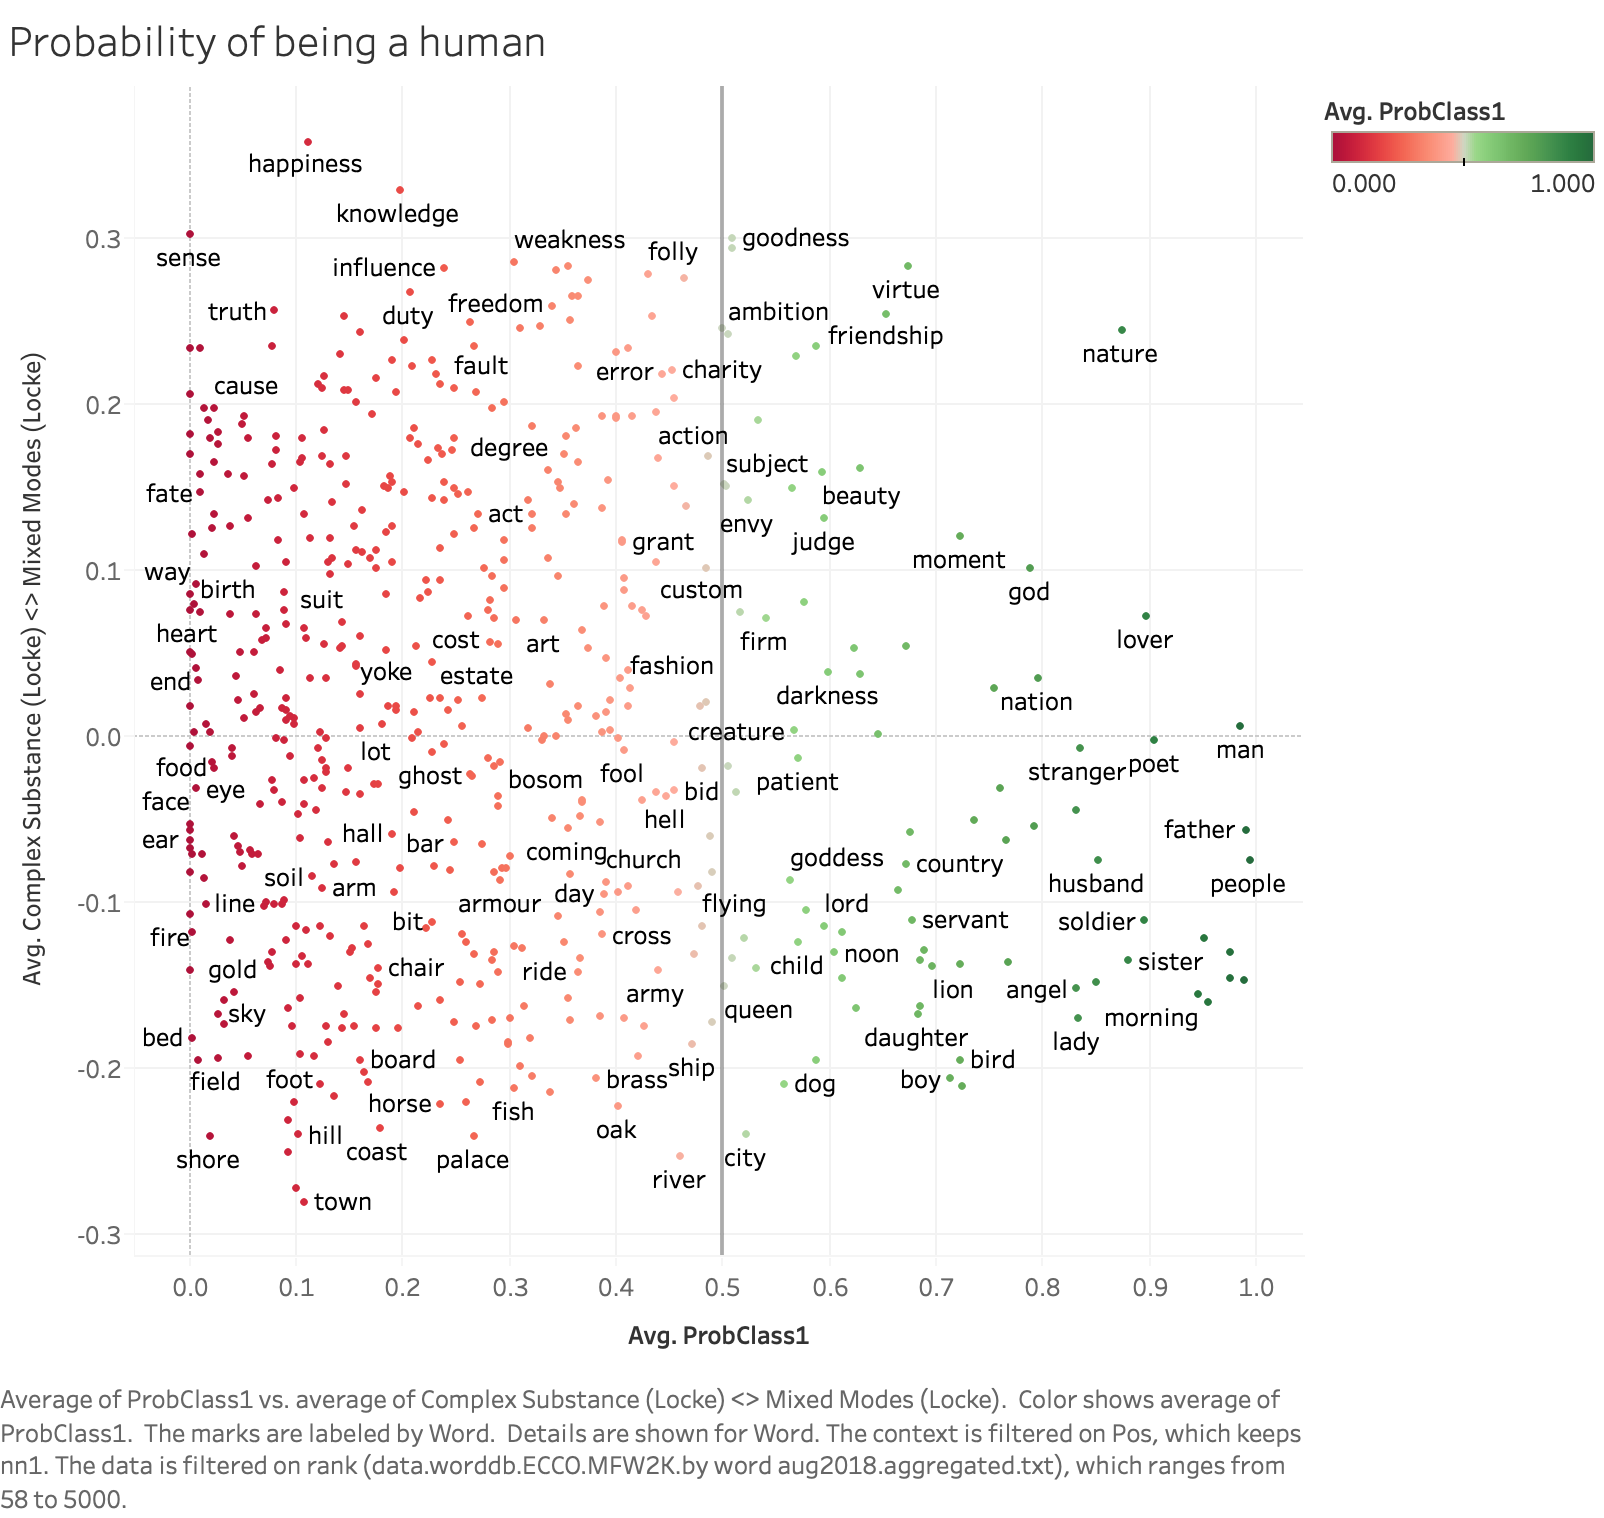

In [58]:
show("images/Probability of being a human V1.png")

**~vs~**

Here are the results with standardization:

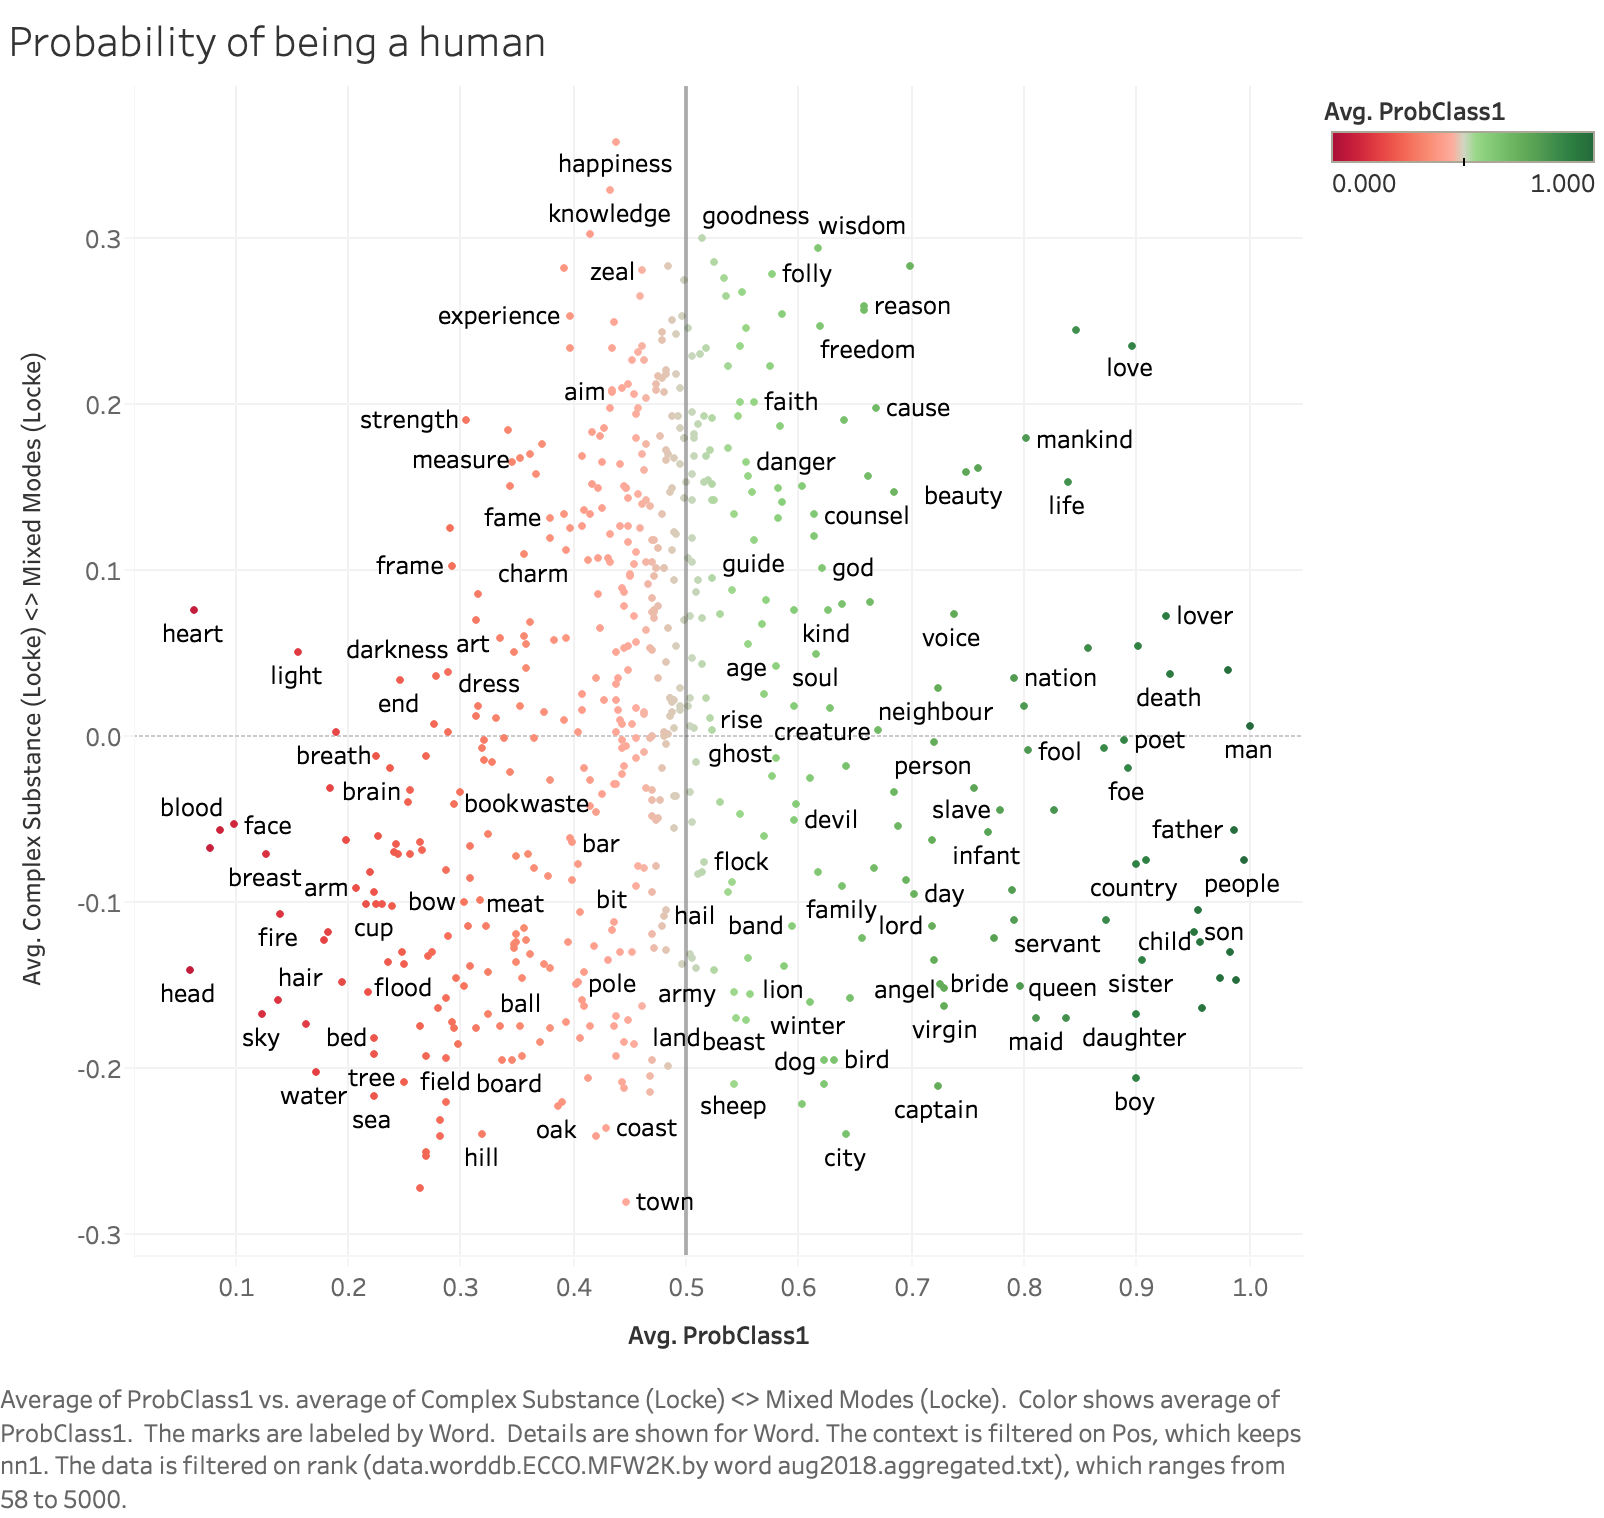

In [59]:
show("images/Probability of being a human V2.png")

**Switching to rel_word** doesn't seem to have done much

Final form:

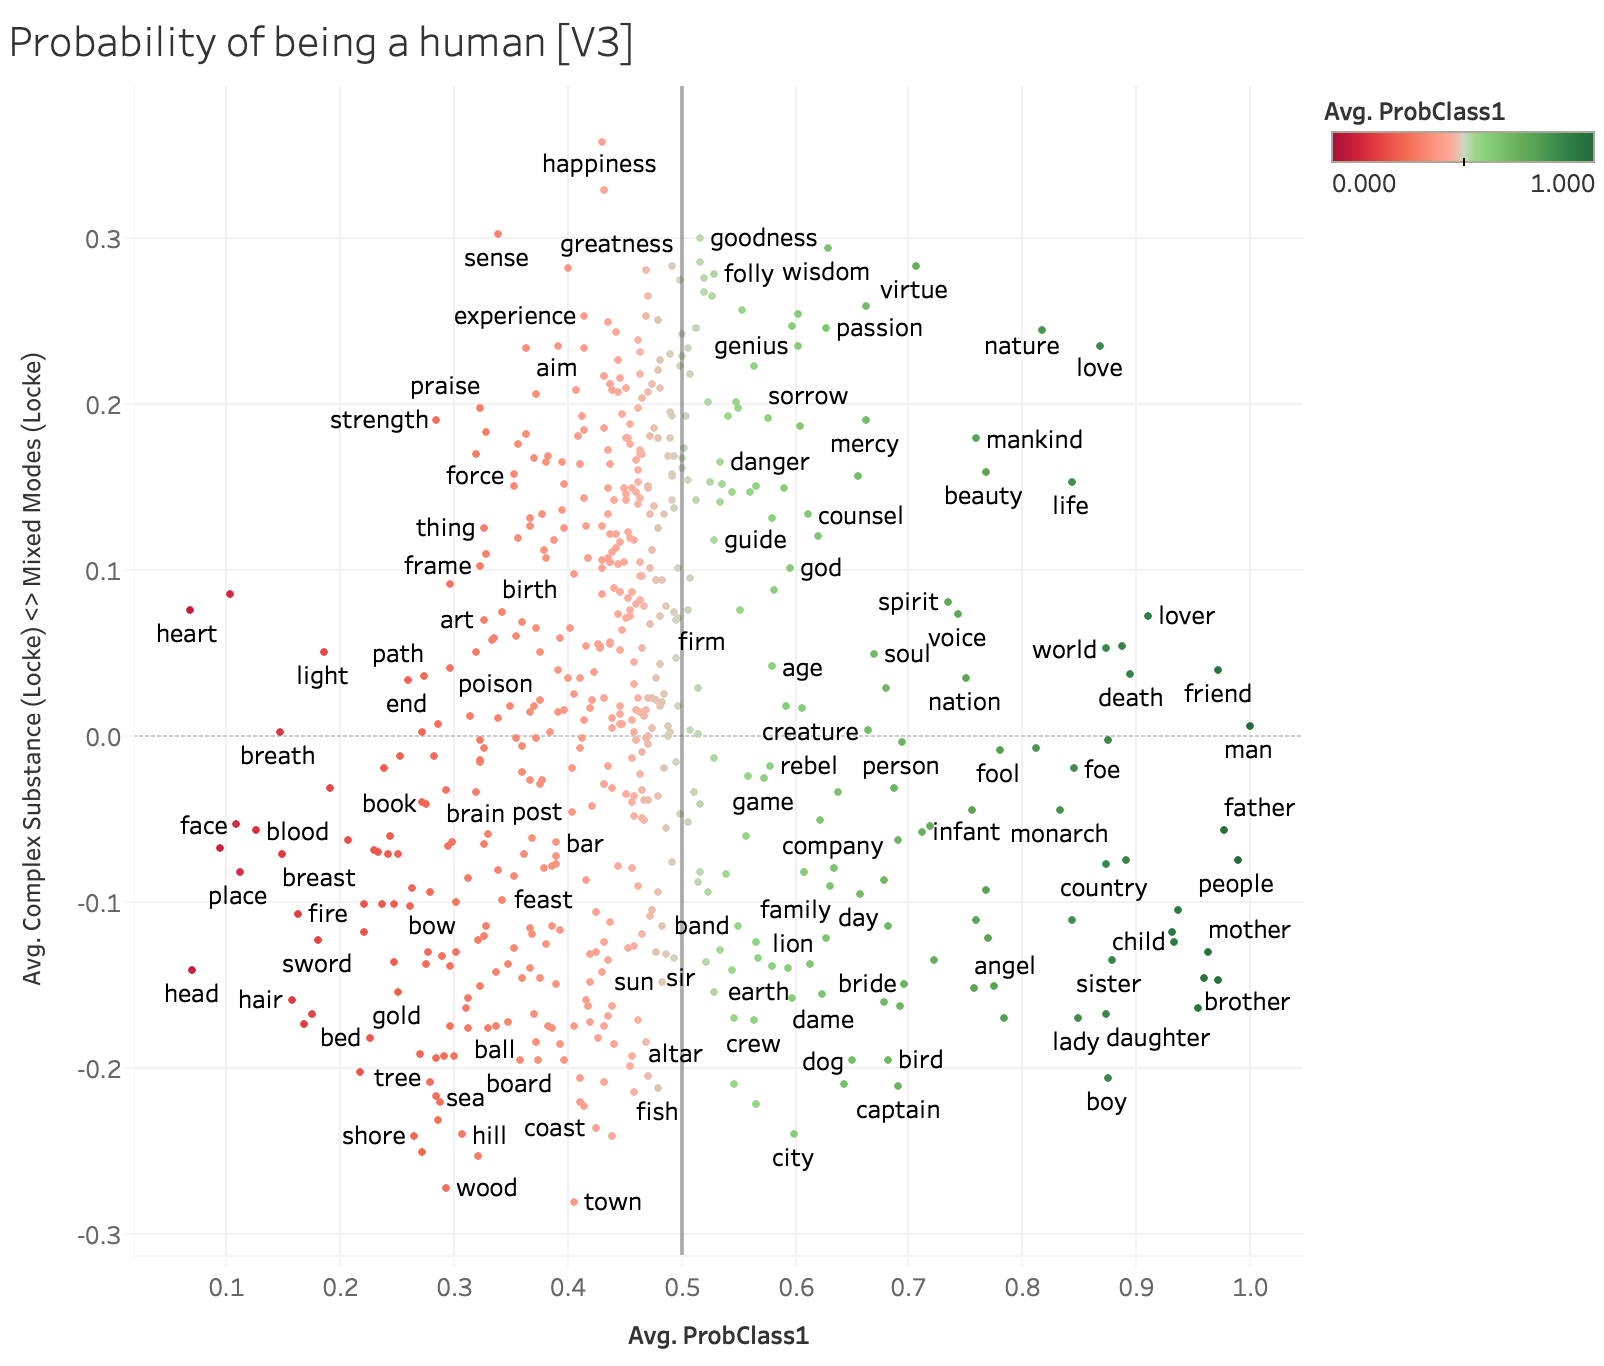

In [61]:
show('images/Probability of being a human [V3].png')

----
#### 2. There do seem to be interesting trends

Like this one. My reading:
* (C1) the human-like-ness of ancien regime abstractions *mercy, truth* and *honour* is falling from before or early C18; 
* (C2) the bourgeois abstractions of *virtue, nation,* and *nature* all have a more enduring human likeness through C18.
* (C3) body parts lose and gain personhood in the same pattern as their frequency.
    * *Is this meaningful theoretically or is as an artifact of the data?*

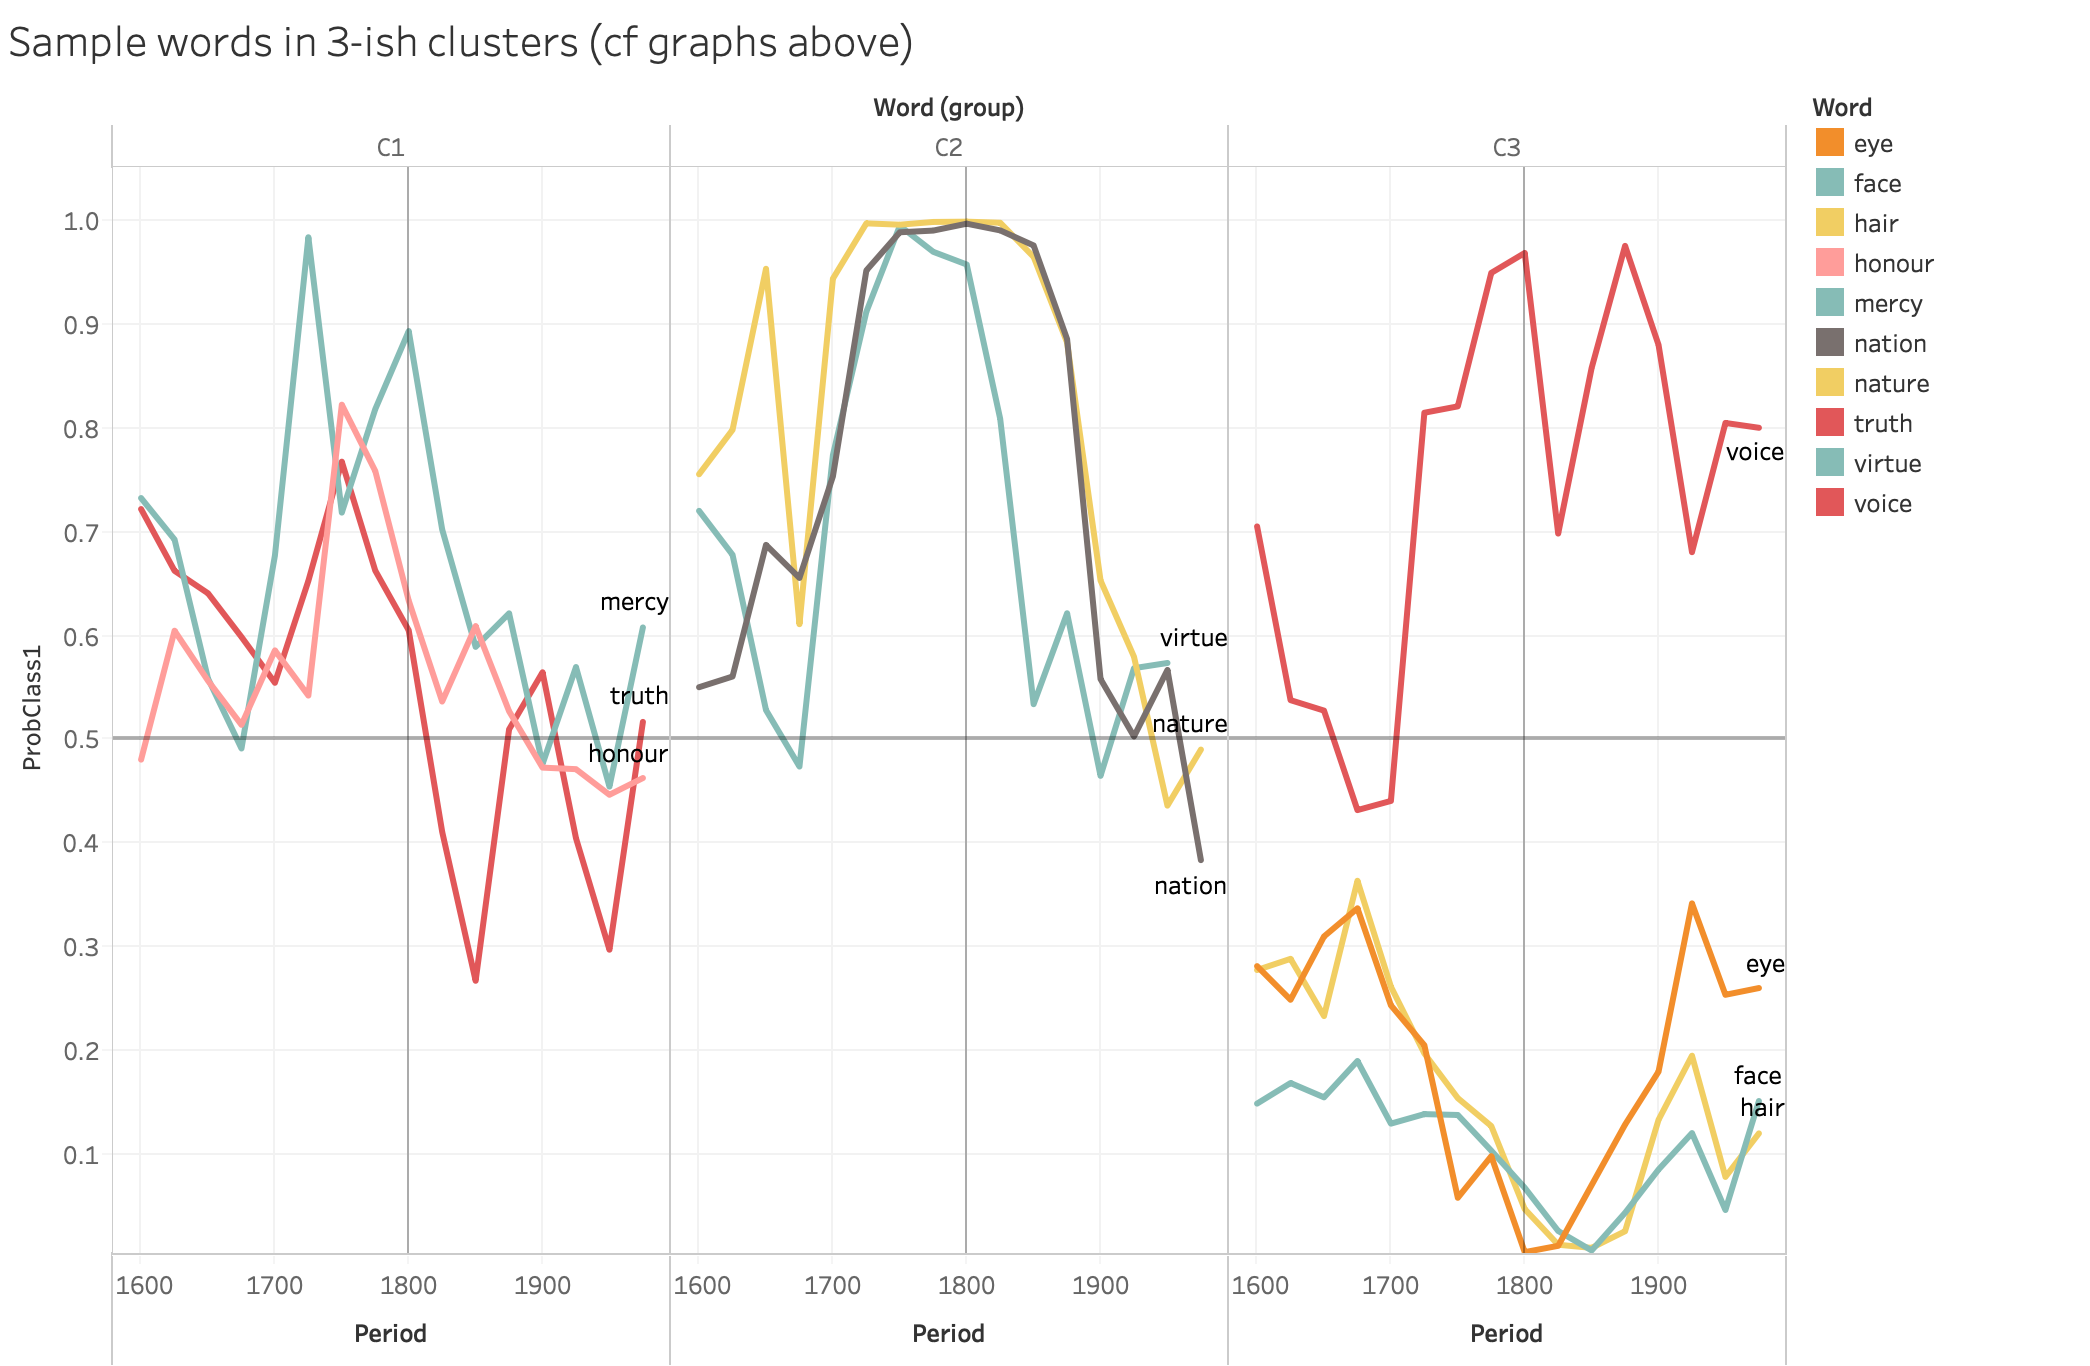

In [62]:
show('images/Sample words in 3-ish clusters (cf graphs above).png')

...which resembles this one on the Agency Index:

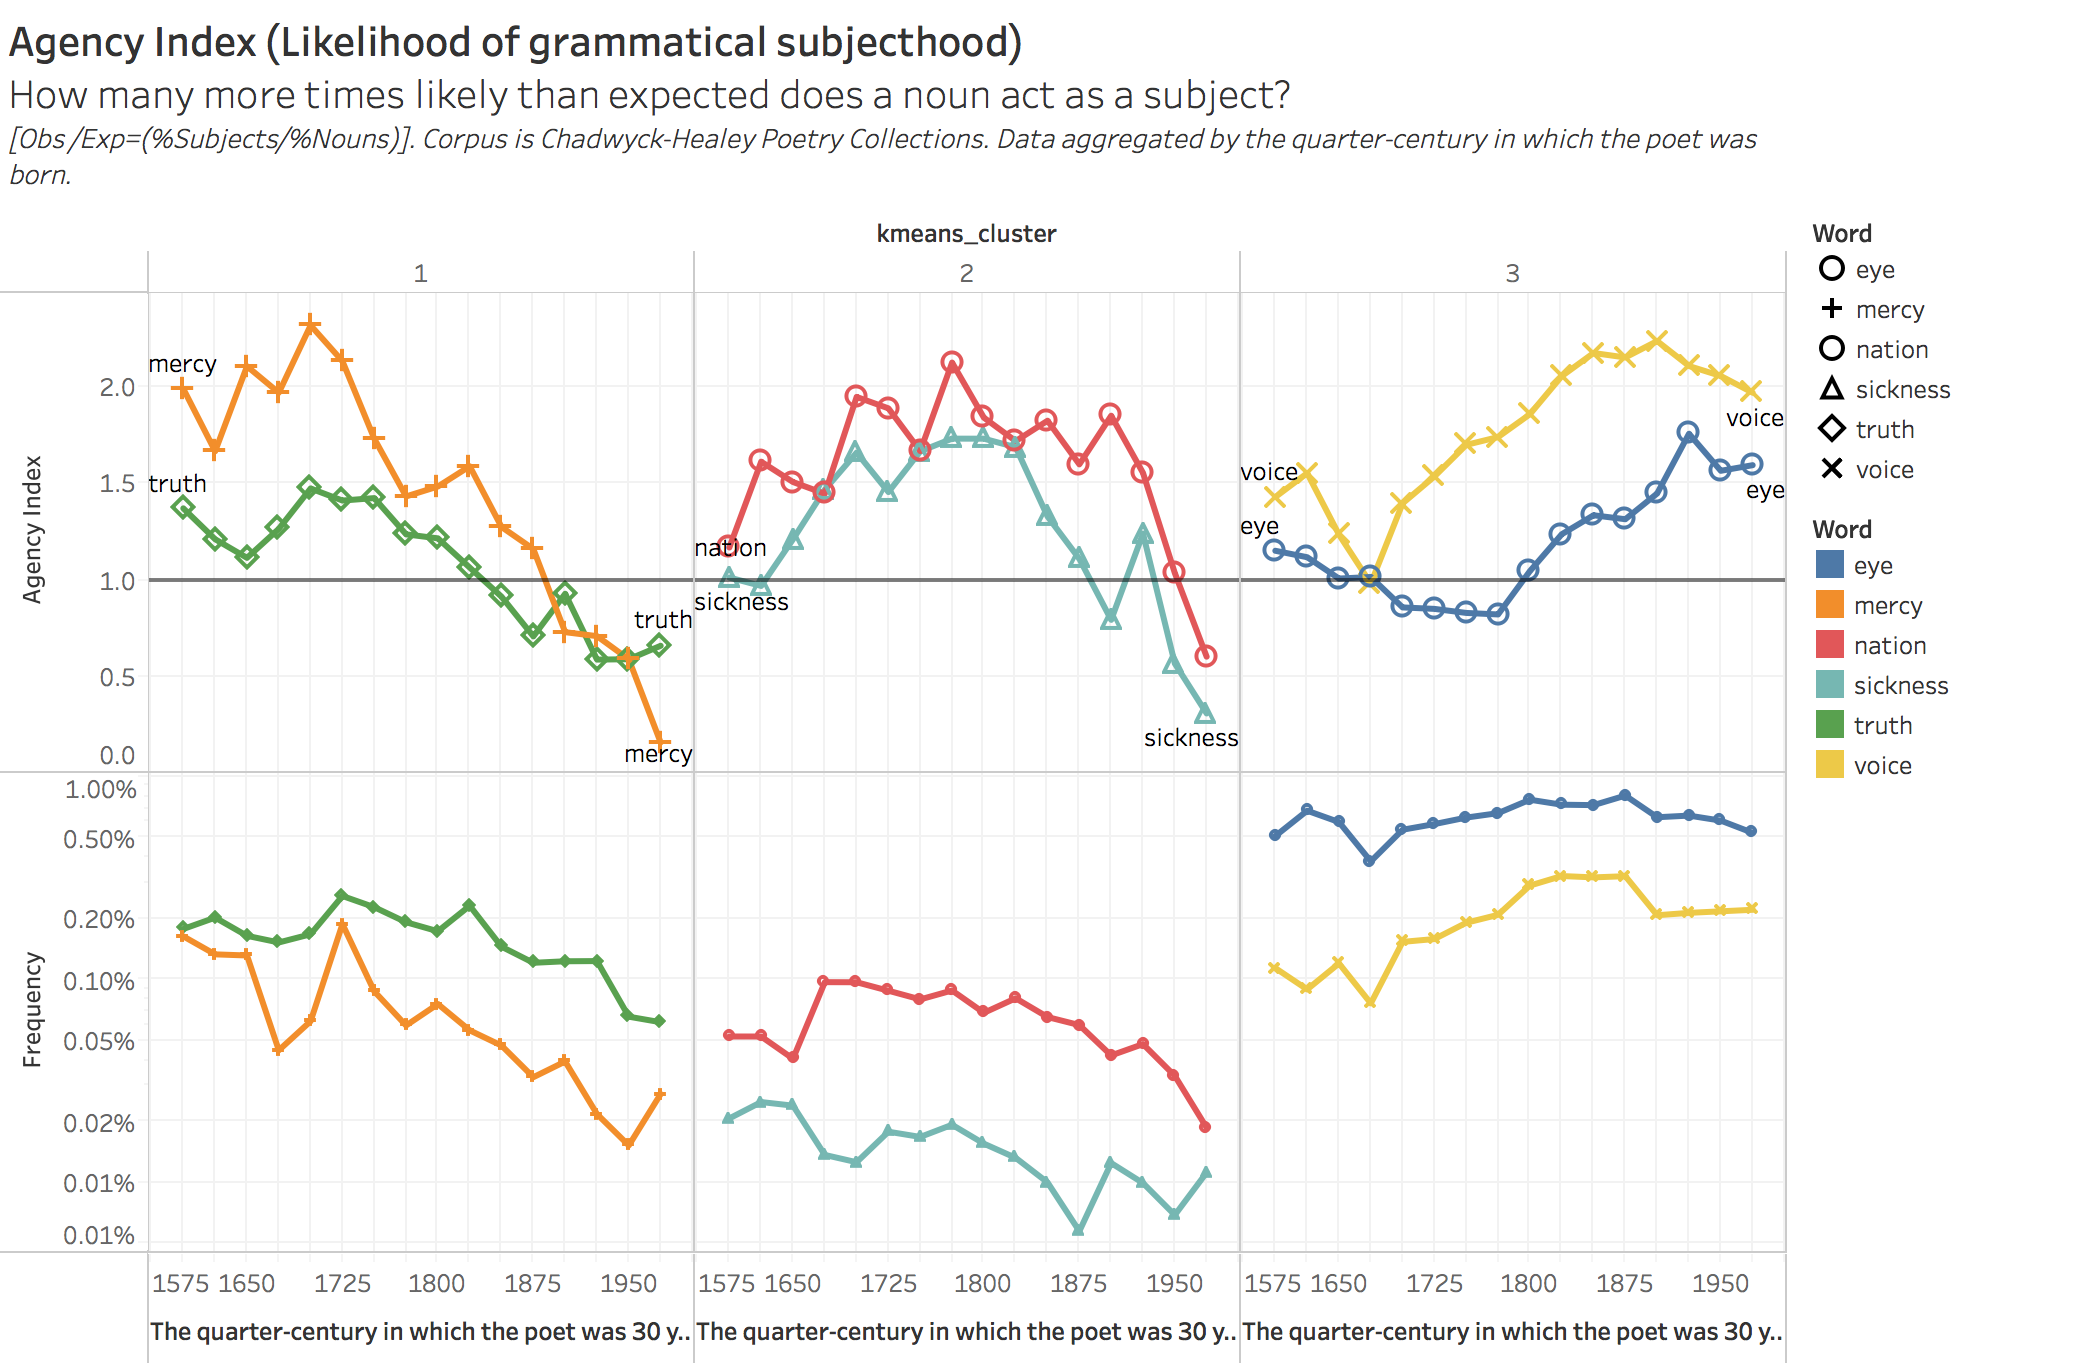

In [63]:
show('images/Word Highlighter 3.png')

### Analyzing features in the model

Which words (or rel_words) predict human nouns? Which features are responsible for the model?

In [64]:
def synthesize_feature_data(idir='data_booknlp/data_by_quarter_century__model_results/'):
    for fn in os.listdir(idir):
        if not fn.endswith('.txt'): continue
        fnfn=os.path.join(idir,fn)
        ld=tools.read_ld(fnfn)
        for d in ld:
            del d['']
            d['fn']=fn
            d['rel'],d['word']=d['feat'].split('_',1) if '_' in d['feat'] else (d['feat'],d['feat'])
            yield d

In [65]:
synthesize_feature_data().next()

>> streaming as tsv: data_booknlp/data_by_quarter_century__model_results/1875-1899.txt
   done [0.0 seconds]


{u'coeff': u'-0.004218869628440757',
 u'count': u'271879',
 u'feat': u'nsubj',
 'fn': '1875-1899.txt',
 u'rank': u'1',
 'rel': u'nsubj',
 'word': u'nsubj'}

In [67]:
#tools.writegen('data_booknlp/data.classification_feature_coefficients.txt', synthesize_feature_data)
# last run: 2/4/19 21:14

#tools.writegen('data_booknlp/data.classification_feature_coefficients.txt', synthesize_feature_data)
# last run: V4, 2/5/19 12:05

### Results 

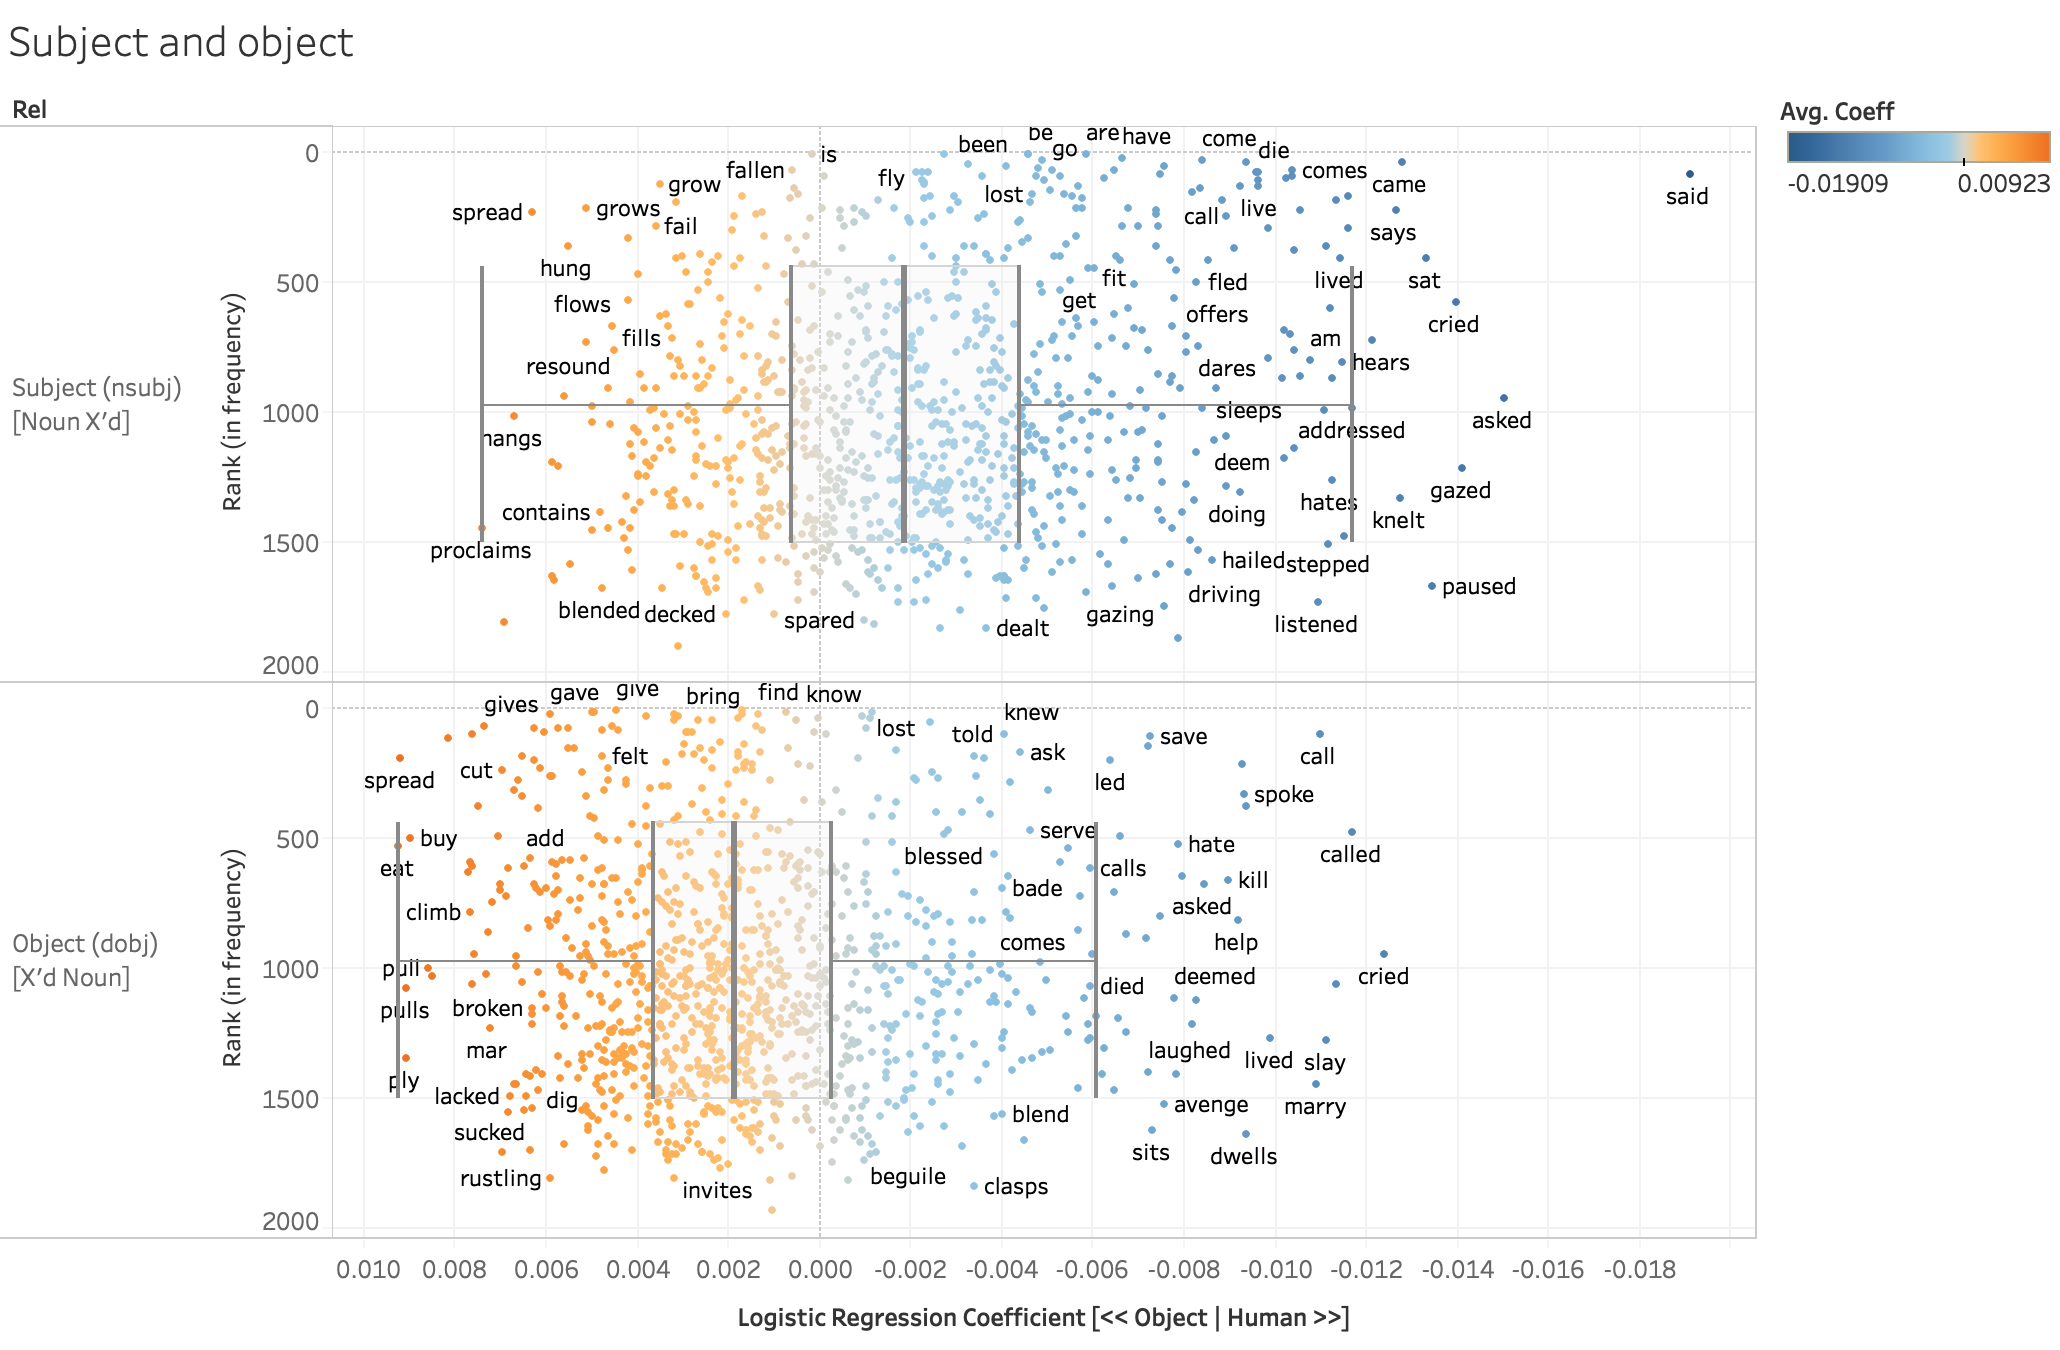

In [68]:
show('figures/Subject and object.png',1000)

## Measuring K-means in this human likeness index

In [1]:
from lit.tools import stats
import pandas as pd
DFN1 = 'data_booknlp/data.classification_probabilities_by_word_by_period.V4.txt'
DFN2 = 'data_booknlp/data.classification_feature_coefficients.txt'

In [2]:
df1 = pd.read_csv(DFN1,encoding='utf-8',sep='\t').fillna(0)
df1 = df1.loc[df1.word!='who']  # don't konw why this word is causing troubles
#df1.head()

In [3]:
# make crosstab
df1_pivot=df1.pivot_table(index='word',columns='period',values='ProbClass1', aggfunc='mean')
#df1_pivot.head()

In [4]:
# filter to top N words
lim_cols=2000
df1_pivot = df1_pivot.loc[df1_pivot.abs().sum(axis=1).nlargest(lim_cols).index]
df1_pivot = df1_pivot.fillna(0)
#df1_pivot.shape

In [5]:
df1_results=stats.analyze_as_dist(df1_pivot,n_kmeans=5)
df1_results

>> dist(datadf) 2019-02-05 18:32:07
>> kmeans(datadf) 2019-02-05 18:32:07
>> corr_with_cluster(datadf) 2019-02-05 18:32:09
>> regressions(datadf) 2019-02-05 18:32:10
>> tsne(datadf) 2019-02-05 18:32:25


,kmeans_cluster,kmeans_cluster_corr_r,kmeans_cluster_corr_p,polyfit_r^2,polyfit_p,tsne_V2,tsne_V1
word,,,,,,,
man,2,0.998297,1.107433e-18,0.065480,0.643910,49.130215,19.019329
people,2,0.898650,2.244702e-06,0.218140,0.201994,46.838520,13.268300
friend,1,0.459468,7.337861e-02,0.221822,0.195891,-8.251590,11.029244
woman,2,0.888257,4.320523e-06,0.289684,0.108251,46.509682,13.383260
father,2,0.998329,9.696761e-19,0.076327,0.596854,48.719574,18.696602
other,3,-0.154243,5.684370e-01,0.139747,0.375899,-11.758357,0.894488
child,2,0.798940,2.054335e-04,0.327660,0.075741,39.280399,-18.826139
king,3,0.429084,9.721940e-02,0.619296,0.001879,-14.170627,38.840553
mother,2,0.994278,5.301309e-15,0.098991,0.507855,47.973133,18.005348


In [6]:
df1_results.to_csv(DFN1.replace('.txt','.dist_analysis.txt'), sep='\t', encoding='utf-8')

## Putting nouns and features back together again

I'd like to see the nouns and features together: "dobj_taste" and "joy". Do I use a network? I can put the most upstream form of data into Tableau; or also the summary/crosstab counts. Maybe the crosstab counts, in long/Tableau form, will be what I need.

In [8]:
import os,pandas as pd

def get_most_upstream_data():
    # load the giant spreadsheet
    booknlp_like_data_fn = 'data_booknlp/data.booknlp_like_data.chadwyck_poetry.lemmatized.txt.gz'
    df=pd.read_csv(booknlp_like_data_fn,sep='\t',encoding='utf-8',quoting=3,error_bad_lines=False)
    df['group']=[fn2group.get(fn,'') for fn in df['fn']]
    return df

In [9]:
#df['group'].shape, df['group'].loc[df.group!=''].shape

In [58]:
def make_crosstab_counts_long_form(idir='data_booknlp/data_by_quarter_century__crosstabs__rel_lemma/'):
    from scipy.stats import zscore
    for fn in sorted(os.listdir(idir)):
        if not fn.endswith('.txt'): continue
        print '>>',fn,'...'
        df_tabs=pd.read_csv(os.path.join(idir,fn),sep='\t',encoding='utf-8',quoting=3,error_bad_lines=False).fillna('').set_index('word')        
        df_tabs_q=df_tabs.select_dtypes('number')
        df_tabs_z=df_tabs_q.apply(zscore)
        sumval=float(df_tabs_q.sum().sum())
        for word in df_tabs.index:
            rowd=df_tabs_q.loc[word].to_dict()
            row_sum=float(sum(rowd.values()))
            for colname,colval in rowd.items():
                if not colval: continue
                if colname.startswith('_'): continue
                colval_fpm=colval/sumval*1000000
                colval_z=df_tabs_z.loc[word][colname]
                colval_perc_word=colval/row_sum
                odx={'fn':fn,'word':word,'feat':colname,'count':colval,'fpm':colval_fpm,'z':colval_z,
                    'perc_of_word':colval_perc_word}
                yield odx

In [59]:
make_crosstab_counts_long_form().next()

>> 1600-1624.txt ...


{'count': 1,
 'feat': u'nsubj_come',
 'fn': '1600-1624.txt',
 'fpm': 1.6462585481975116,
 'perc_of_word': 0.08333333333333333,
 'word': u'a',
 'z': 0.17678469709190409}

In [60]:
from lit import tools
tools.writegen('data_booknlp/data.crosstab_long_form.txt',make_crosstab_counts_long_form)

>> 1600-1624.txt ...
>> 1625-1649.txt ...
>> 1650-1674.txt ...
>> 1675-1699.txt ...
>> 1700-1724.txt ...
>> 1725-1749.txt ...
>> 1750-1774.txt ...
>> 1775-1799.txt ...
>> 1800-1824.txt ...
>> 1825-1849.txt ...
>> 1850-1874.txt ...
>> 1875-1899.txt ...
>> 1900-1924.txt ...
>> 1925-1949.txt ...
>> 1950-1974.txt ...
>> 1975-1999.txt ...
